In [2]:
import cv2
import mediapipe as mp
import numpy as np
import logging
import cProfile
from scipy.stats import circmean, circstd

cv2.setNumThreads(1)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.7)
mp_drawing = mp.solutions.drawing_utils

In [3]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    # define print method
    
    def __str__(self):
        return f'({self.x}, {self.y})'

def calculate_distance(point1, point2):
    return np.sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2)
                # uncomment if 3d Point
                #    + (point1['z'] - point2['z'])**2)
                
def calculate_horizontal_distance(point1, point2, frame_width):
    return abs(point1.x - point2.x) * frame_width

def calculate_vertical_distance(point1, point2, frame_height):
    return abs(point1.y - point2.y) * frame_height

def calculate_central_point(landmark1, landmark2):
    return Point((landmark1.x + landmark2.x) / 2, (landmark1.y + landmark2.y) / 2)

def low_pass_filter(new_value, prev_value, alpha=0.8):
    return alpha * new_value + (1 - alpha) * prev_value

def calculate_foot_slope(ankle, toe):
    slope = (toe.y - ankle.y) / (toe.x - ankle.x)
    logging.info(f"Right foot slope: {slope}")

    return slope

def get_keypoints(landmarks):
        # Convert NormalizedLandmark to Point
        left_hip = Point(
            landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
            landmarks[mp_pose.PoseLandmark.LEFT_HIP].y,
        )
        right_hip = Point(
            landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x,
            landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y,
        )
        nose = Point(
            landmarks[mp_pose.PoseLandmark.NOSE].x,
            landmarks[mp_pose.PoseLandmark.NOSE].y,
        )
        left_ankle = Point(
            landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x,
            landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y,
        )
        right_ankle = Point(
            landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].x,
            landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y,
        )
        left_toe = Point(
            landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
            landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y,
        )
        right_toe = Point(
            landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].x,
            landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y,
        )
        left_shoulder = Point(
            landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
            landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y,
        )
        right_shoulder = Point(
            landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x,
            landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y,
        )
        left_knee = Point(
            landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
            landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y,
        )
        right_knee = Point(
            landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].x,
            landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y,
        )
        keypoints = {
            "NOSE": nose,
            "LEFT_SHOULDER": left_shoulder,
            "RIGHT_SHOULDER": right_shoulder,
            "LEFT_HIP": left_hip,
            "RIGHT_HIP": right_hip,
            "LEFT_KNEE": left_knee,
            "RIGHT_KNEE": right_knee,
            "LEFT_ANKLE": left_ankle,
            "RIGHT_ANKLE": right_ankle,
            "LEFT_TOE": left_toe,
            "RIGHT_TOE": right_toe,
            
        }
        return keypoints

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [4]:
def process_gswt(
    video_path,
    person_height_in_cm,
    distance_required_in_cm,
    movement_threshold=0.02,
    debug=True,
):
    logging.info("Starting video processing")

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps == 0:
        logging.error("Cannot determine the frame rate (FPS) of the video.")
        return 0, 0, 0  # Default values for stride length, elapsed time, and speed

    start_frame_id = None
    end_frame_id = None
    start_position = None
    distance_walked = 0
    timer_started = False
    strides = []
    
    central_point = None

    pixels_to_cm_ratio = None
    start_line = None
    is_start_line_set = False
    ground_line = None

    ground_threshold = 0.08
    start_line_offset = 0.01

    previous_gray = None
    previous_keypoints = None
    foot_contact_start = False  # Flag to track first contact
    foot_off_ground = False  # Flag to track if foot is lifted off ground
    reset_needed = False  # Flag to reset after stride is recorded
    initial_foot_slope = None  # Initial slope of the foot
    keypoints_over_time = []

    frame_counter = 0
    confirm_frames = 5
    

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            logging.warning("End of video or cannot read the video file")
            break

        current_frame_id = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        current_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        logging.info(
            f"===================== Processing frame {current_frame_id} =================================="
        )
        if results.pose_landmarks:
            # Draw pose landmarks
            if debug:
                mp_drawing.draw_landmarks(
                        frame,
                        results.pose_landmarks,
                        mp_pose.POSE_CONNECTIONS,
                        mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                        mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2),
                    )
            
            landmarks = results.pose_landmarks.landmark
            
            keypoints = get_keypoints(landmarks)
            
            keypoint_array = np.array(
                [[kp.x * frame.shape[1], kp.y * frame.shape[0]] for kp in keypoints.values()],
                dtype=np.float32
            ).reshape(-1, 1, 2)

            central_ankle = calculate_central_point(keypoints["LEFT_ANKLE"], keypoints["RIGHT_ANKLE"])
            logging.info(f"Central ankle point: {central_ankle}")

            # Calculate the height of the person in px
            estimated_height_in_px = calculate_vertical_distance(keypoints["NOSE"], central_ankle, frame.shape[0])   # Possibly add a offset to the height

            if pixels_to_cm_ratio is None:
                pixels_to_cm_ratio = estimated_height_in_px / person_height_in_cm
                logging.info(f"Pixels to cm ratio: {pixels_to_cm_ratio} is set")

            # Fix central point of the person using hip points
            central_point = calculate_central_point(keypoints["LEFT_HIP"], keypoints["RIGHT_HIP"])
            logging.info(f"Central point: {central_point}")

            if ground_line is None:
                # Set the ground line slightly below the ankle
                ground_line = central_ankle.y + ground_threshold
                logging.info(f"Ground line set at Y: {ground_line}")
            else:
                if debug:
                    cv2.line(
                        frame,
                        (0, int(ground_line * frame.shape[0])),
                        (frame.shape[1], int(ground_line * frame.shape[0])),
                        (0, 255, 0),  # Green color for the ground line
                        2,
                    )

            if start_position is None and central_point is not None and not is_start_line_set:
                # Set start line slightly in front of the initial frontmost toe
                frame_counter+=1
                if frame_counter >= confirm_frames:
                    is_start_line_set = True
                    start_line = max(keypoints["LEFT_TOE"].x, keypoints["RIGHT_TOE"].x) + start_line_offset
                    logging.info(f"Start line set at X: {start_line}")

            # Draw the start line
            if debug and is_start_line_set:
                # Convert normalized start line X position to pixel coordinates
                start_line_pixel_x = int(start_line * frame.shape[1])

                cv2.line(
                    frame,
                    (start_line_pixel_x, 0),
                    (start_line_pixel_x, frame.shape[0]),
                    (255, 0, 0),  # Blue color for the start line
                    2,
                )

            if not timer_started and is_start_line_set:
                # Check if either toe crosses the start line
                if max(keypoints["LEFT_TOE"].x, keypoints["RIGHT_TOE"].x) >= start_line:
                    start_position = central_point
                    start_frame_id = current_frame_id
                    timer_started = True
                    logging.info(f"Timer started at frame {start_frame_id}")

            # Main Processing only when the timer has started
            if timer_started:
                distance_walked = (
                    calculate_horizontal_distance(start_position, central_point, frame.shape[1])
                    / pixels_to_cm_ratio
                )
                logging.info(f"Distance walked: {distance_walked} cm")

                # End processing
                if distance_walked >= distance_required_in_cm:
                    end_frame_id = current_frame_id
                    logging.info(
                        f"Distance: {distance_required_in_cm} cm is completed - {distance_walked} cm"
                    )
                    break
                
                
                
            # Display timer and distance
            if timer_started and start_frame_id is not None:
                elapsed_time = (current_frame_id - start_frame_id) / fps
                if end_frame_id is not None:
                    distance_walked = (
                        calculate_horizontal_distance(start_position, central_point, frame.shape[1])
                        / pixels_to_cm_ratio
                    )
                    elapsed_time = (end_frame_id - start_frame_id) / fps
                if debug:
                    cv2.putText(
                        frame,
                        f"Time: {elapsed_time:.2f} sec",
                        (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1,
                        (0, 255, 0),
                        2,
                        cv2.LINE_AA,
                    )
                    cv2.putText(
                        frame,
                        f"Distance: {distance_walked:.2f} cm",
                        (10, 70),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1,
                        (0, 255, 0),
                        2,
                        cv2.LINE_AA,
                    )
            else:
                if debug:
                    cv2.putText(
                        frame,
                        f"Timer not started",
                        (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1,
                        (0, 0, 255),
                        2,
                        cv2.LINE_AA,
                    )
            
            if not timer_started and start_position is None:
                logging.info("Waiting for the person to start walking")

            # Calculate motion vectors using optical flow
            if timer_started and previous_gray is not None and previous_keypoints is not None:
                p1, st, err = cv2.calcOpticalFlowPyrLK(
                    previous_gray, current_gray, previous_keypoints, None
                )
                
                current_frame_keypoints = {}

                for i, (new, old) in enumerate(zip(p1, previous_keypoints)):
                    new_x, new_y = new.ravel()
                    old_x, old_y = old.ravel()

                    motion_magnitude = np.sqrt((new_x - old_x) ** 2 + (new_y - old_y) ** 2)
                    motion_angle = np.arctan2(new_y - old_y, new_x - old_x)

                    key = list(keypoints.keys())[i]
                    current_frame_keypoints[key] = (motion_magnitude, motion_angle)
                    logging.info(
                        f"{key} - Magnitude: {motion_magnitude}, Angle: {motion_angle} radians"
                    )

                    # Optionally, visualize the motion (debugging)
                    if debug:
                        cv2.arrowedLine(
                            frame,
                            (int(old_x), int(old_y)),
                            (int(new_x), int(new_y)),
                            (0, 255, 0),
                            2,
                            tipLength=0.5
                        )
                keypoints_over_time.append(current_frame_keypoints)
                previous_keypoints = p1
            else:
                previous_keypoints = keypoint_array
            
            previous_gray = current_gray
            
            
            if initial_foot_slope is None:
                initial_foot_slope = calculate_foot_slope(keypoints["RIGHT_ANKLE"], keypoints["RIGHT_TOE"])
                right_slope = initial_foot_slope
                logging.info(f"Initial foot slope: {initial_foot_slope}")
            else:
                right_slope = calculate_foot_slope(keypoints["RIGHT_ANKLE"], keypoints["RIGHT_TOE"])
                logging.info(f"Right foot slope: {right_slope}")
            
            # Detect foot contact with the ground
            if abs(right_slope) < initial_foot_slope:
                logging.info(f"Right foot is parallel to the ground")
                if not foot_contact_start and not reset_needed:
                    # First ground contact
                    foot_contact_start = True
                    foot_off_ground = False
                    initial_contact_position = keypoints["RIGHT_TOE"]
                    logging.info("First ground contact detected")

                elif foot_off_ground and reset_needed:
                    # Second ground contact, calculate stride
                    final_contact_position = keypoints["RIGHT_TOE"]
                    stride_length = (
                        calculate_horizontal_distance(
                            final_contact_position, initial_contact_position, frame.shape[1]
                        )
                        / pixels_to_cm_ratio
                    )
                    strides.append(stride_length)
                    logging.info(f"Stride length recorded: {stride_length} cm")

                    # Reset flags for the next stride detection
                    reset_needed = False
                    foot_contact_start = False
                    foot_off_ground = False
                    initial_contact_position = keypoints["RIGHT_TOE"]
            else:
                # Foot off ground
                if foot_contact_start and not reset_needed:
                    foot_off_ground = True
                    logging.info("Foot is off the ground")

                    # Allow reset to detect the next stride
                    reset_needed = True

            if debug:
                cv2.putText(
                    frame,
                    f"Right foot slope: {right_slope}",
                    (10, 90),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (255, 255, 0),
                    2,
                    cv2.LINE_AA,
                )
                cv2.putText(
                    frame,
                    f"Foot touching ground: {'YES' if foot_contact_start and abs(right_slope) < 0.9 else 'NO'}",
                    (10, 120),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (255, 255, 0),  # Yellow text for stride count
                    2,
                    cv2.LINE_AA,
                )
        if debug:
            # Display the frame
            cv2.imshow("Frame", frame)
            if cv2.waitKey(5) & 0xFF == 27:
                logging.info("Process interrupted by user")
                break
    
    cap.release()
    cv2.destroyAllWindows()
    logging.info("================================= Post Processing =================================")
    if strides:
        average_stride_length = np.mean(strides)
        logging.info(f"strides: {strides}")
        logging.info(f"Average stride length: {average_stride_length} cm")
        strides_per_second = len(strides) / elapsed_time if elapsed_time > 0 else 0
        logging.info(f"Strides per second: {strides_per_second}")
    else:
        average_stride_length = 0
        logging.info("No strides detected")
    
    
    
    # def ema(data, alpha=0.3):
    #     ema_result = [data[0]]  # Start with the first value
    #     for i in range(1, len(data)):
    #         ema_result.append(alpha * data[i] + (1 - alpha) * ema_result[i-1])
    #     return ema_result
    # if keypoints_over_time:
    #     keypoint_mean_magnitudes = {
    #         keypoint: sum(ema([frame[keypoint][0] for frame in keypoints_over_time])) / len(keypoints_over_time)
    #         for keypoint in keypoints_over_time[0]
    #     }
    #     keypoint_std_devs = {
    #         keypoint: np.std(ema([frame[keypoint][0] for frame in keypoints_over_time]))
    #         for keypoint in keypoints_over_time[0]
    #     }
    #     keypoint_circular_mean = {
    #         keypoint: circmean(ema([frame[keypoint][1] for frame in keypoints_over_time]), high=np.pi, low=-np.pi)
    #         for keypoint in keypoints_over_time[0]
    #     }
    #     keypoint_circular_std = {
    #         keypoint: circstd(ema([frame[keypoint][1] for frame in keypoints_over_time]), high=np.pi, low=-np.pi)
    #         for keypoint in keypoints_over_time[0]
    #     }
    
    # def moving_average(data, window_size=5):
    #     return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    # if keypoints_over_time:
    #     keypoint_mean_magnitudes = {
    #         keypoint: sum(moving_average([frame[keypoint][0] for frame in keypoints_over_time])) / len(keypoints_over_time)
    #         for keypoint in keypoints_over_time[0]
    #     }
    #     keypoint_std_devs = {
    #         keypoint: np.std(moving_average([frame[keypoint][0] for frame in keypoints_over_time]))
    #         for keypoint in keypoints_over_time[0]
    #     }
    #     keypoint_circular_mean = {
    #         keypoint: circmean(moving_average([frame[keypoint][1] for frame in keypoints_over_time]), high=np.pi, low=-np.pi)
    #         for keypoint in keypoints_over_time[0]
    #     }
    #     keypoint_circular_std = {
    #         keypoint: circstd(moving_average([frame[keypoint][1] for frame in keypoints_over_time]), high=np.pi, low=-np.pi)
    #         for keypoint in keypoints_over_time[0]
    #     }
    # no filter version
    if keypoints_over_time:
        keypoint_mean_magnitudes = {
            keypoint: sum(frame[keypoint][0] for frame in keypoints_over_time) / len(keypoints_over_time)
            for keypoint in keypoints_over_time[0]
        }
        keypoint_std_devs = {
            keypoint: np.std([frame[keypoint][0] for frame in keypoints_over_time])
            for keypoint in keypoints_over_time[0]
        }
        keypoint_circular_mean = {
            keypoint: circmean([frame[keypoint][1] for frame in keypoints_over_time], high=np.pi, low=-np.pi)
            for keypoint in keypoints_over_time[0]
        }
        keypoint_circular_std = {
            keypoint: circstd([frame[keypoint][1] for frame in keypoints_over_time], high=np.pi, low=-np.pi)
            for keypoint in keypoints_over_time[0]
        }
        
    else:
        keypoint_std_devs = -1
        keypoint_mean_magnitudes = -1
        logging.info("No keypoints detected")
        

    if timer_started and start_frame_id is not None:
        elapsed_time = (current_frame_id - start_frame_id) / fps
        logging.info(f"Elapsed time: {elapsed_time} seconds")
        average_speed = distance_walked / elapsed_time if elapsed_time > 0 else 0
        logging.info(f"Average speed: {average_speed} cm/second")
    else:
        elapsed_time = 0
        average_speed = 0
        logging.info("Problems detected, unable to calculate")

    return "Gait Speed Walk Test", distance_walked,elapsed_time, average_speed, average_stride_length, keypoint_mean_magnitudes, keypoint_std_devs, keypoint_circular_mean, keypoint_circular_std
# , keypoints_over_time


# video_path = "/Users/brennanlee/Desktop/opencv-healthcare/test/GSWT(forward).mp4"
# video_path = "/Users/brennanlee/Desktop/opencv-healthcare/test/GSWT_normal_youlian.mp4"
# video_path = "/Users/brennanlee/Desktop/opencv-healthcare/test/GSWT_fast_youlian.mp4"
# video_path = "/Users/brennanlee/Desktop/opencv-healthcare/test/GSWT_frail_youlian.mp4"
# person_height = 175  # Example height in meters
# test_name, distance_walked,elapsed_time, average_speed, average_stride_length, keypoint_mean_magnitudes, keypoint_std_devs, keypoint_circular_mean, keypoint_circular_std = process_gswt(
    # video_path, person_height, 400
# )
# , keypoints_over_time 




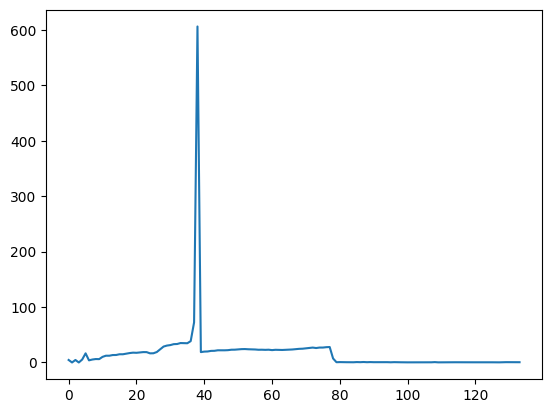

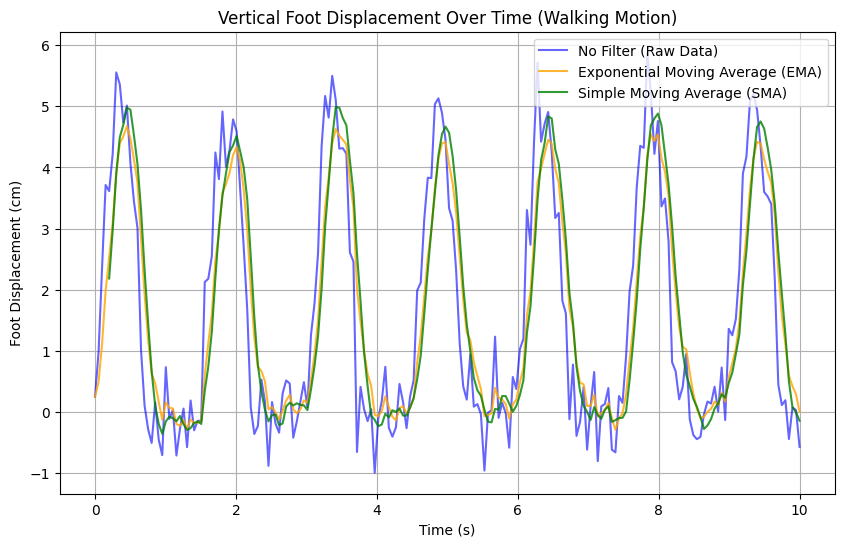

In [31]:
# print(keypoints_over_time)
# convert this to a df
import pandas as pd
df = pd.DataFrame(keypoints_over_time)
df
# plot this df
time_values = df.index
import matplotlib.pyplot as plt
right_hip_data = df['RIGHT_HIP']
right_hip_magnitude = [x[0] for x in right_hip_data]
right_hip_angle = [x[1] for x in right_hip_data]
plt.plot(time_values, right_hip_magnitude)

# find the spike
from scipy.signal import find_peaks
# find which frame has the highest magnitude
peaks, _ = find_peaks(right_hip_magnitude, height=0.1)
peaks

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Mock data: Simulating vertical foot displacement over time during walking
np.random.seed(42)
time = np.linspace(0, 10, 200)  # 10 seconds of data, 200 samples

# Simulating a vertical foot displacement with sine wave patterns (typical of walking cycles)
foot_displacement = np.sin(2 * np.pi * time / 1.5) * 5  # Regular walking, 5 cm peak displacement
foot_displacement = np.clip(foot_displacement, 0, None)  # No negative displacement

# Adding some irregularities to simulate irregular motion
irregularities = np.random.normal(0, 0.5, len(time))
foot_displacement += irregularities

# Exponential Moving Average (EMA)
ema_span = 5
ema = pd.Series(foot_displacement).ewm(span=ema_span, adjust=False).mean()

# Moving Average (SMA)
window_size = 5
sma = pd.Series(foot_displacement).rolling(window=window_size).mean()

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(time, foot_displacement, label='No Filter (Raw Data)', color='blue', alpha=0.6)
plt.plot(time, ema, label='Exponential Moving Average (EMA)', color='orange', alpha=0.8)
plt.plot(time, sma, label='Simple Moving Average (SMA)', color='green', alpha=0.8)

plt.title('Vertical Foot Displacement Over Time (Walking Motion)')
plt.xlabel('Time (s)')
plt.ylabel('Foot Displacement (cm)')
plt.legend()
plt.grid(True)
plt.show()



In [28]:
# Normal walking
video_path = "/Users/brennanlee/Desktop/opencv-healthcare/test/GSWT_normal_youlian.mp4"

person_height = 175  # Example height in meters
(
    test_name,
    normal_distance_walked,
    normal_elapsed_time,
    normal_average_speed,
    normal_average_stride_length,
    normal_keypoint_mean_magnitudes,
    normal_keypoint_std_devs,
    normal_keypoint_circular_mean,
    normal_keypoint_circular_std,
) = process_gswt(video_path, person_height, 400, debug=False)
print(normal_keypoint_mean_magnitudes)
print(normal_keypoint_std_devs)

2024-09-28 05:13:31,692 - INFO - Starting video processing
2024-09-28 05:13:32,441 - INFO - ===================== Processing frame 1 ==================================
2024-09-28 05:13:32,444 - INFO - Central ankle point: (0.07960475236177444, 0.9299815595149994)
2024-09-28 05:13:32,445 - INFO - Pixels to cm ratio: 7.24529003415789 is set
2024-09-28 05:13:32,446 - INFO - Central point: (0.10030108317732811, 0.6422167420387268)
2024-09-28 05:13:32,447 - INFO - Ground line set at Y: 1.0099815595149995
2024-09-28 05:13:32,448 - INFO - Waiting for the person to start walking
2024-09-28 05:13:32,449 - INFO - Right foot slope: 0.5214084843402751
2024-09-28 05:13:32,450 - INFO - Initial foot slope: 0.5214084843402751
2024-09-28 05:13:32,591 - INFO - ===================== Processing frame 2 ==================================
2024-09-28 05:13:32,592 - INFO - Central ankle point: (0.08000633865594864, 0.9292741417884827)
2024-09-28 05:13:32,594 - INFO - Central point: (0.10060486197471619, 0.643

{'NOSE': 22.286337078019073, 'LEFT_SHOULDER': 22.12923871459329, 'RIGHT_SHOULDER': 23.509641718271066, 'LEFT_HIP': 28.601562096529104, 'RIGHT_HIP': 23.454436647795866, 'LEFT_KNEE': 30.360298695964122, 'RIGHT_KNEE': 23.746557179921734, 'LEFT_ANKLE': 7.305157248849212, 'RIGHT_ANKLE': 20.404422904431218, 'LEFT_TOE': 22.985318360029172, 'RIGHT_TOE': 19.854543549299084}
{'NOSE': 6.222413840144862, 'LEFT_SHOULDER': 7.162600897013695, 'RIGHT_SHOULDER': 8.62164578203012, 'LEFT_HIP': 45.48048588558322, 'RIGHT_HIP': 31.375693602511657, 'LEFT_KNEE': 77.48437678404939, 'RIGHT_KNEE': 14.466751612515665, 'LEFT_ANKLE': 14.224343740092442, 'RIGHT_ANKLE': 72.4161596675392, 'LEFT_TOE': 31.850070573092587, 'RIGHT_TOE': 28.667241188318158}


In [29]:
# Fast walking
video_path = "/Users/brennanlee/Desktop/opencv-healthcare/test/GSWT_fast_youlian.mp4"
person_height = 175  # Example height in meters
(
    test_name,
    fast_distance_walked,
    fast_elapsed_time,
    fast_average_speed,
    fast_average_stride_length,
    fast_keypoint_mean_magnitudes,
    fast_keypoint_std_devs,
    fast_keypoint_circular_mean,
    fast_keypoint_circular_std
) = process_gswt(video_path, person_height, 400)
print(f"test name: {test_name}")
print(f"distance walked: {fast_distance_walked}")
print(f"elapsed time: {fast_elapsed_time}")
print(f"average speed: {fast_average_speed}")
print(f"average stride length: {fast_average_stride_length}")
print(f"keypoint mean magnitudes: {fast_keypoint_mean_magnitudes}")
print(f"keypoint std devs: {fast_keypoint_std_devs}")
print(f"keypoint circular mean: {fast_keypoint_circular_mean}")
print(f"keypoint circular std: {fast_keypoint_circular_std}")
print(f"keypoint circular std: {fast_keypoint_circular_std}")

2024-09-28 05:13:52,762 - INFO - Starting video processing
2024-09-28 05:13:53,171 - INFO - ===================== Processing frame 1 ==================================
2024-09-28 05:13:53,673 - INFO - ===================== Processing frame 2 ==================================
2024-09-28 05:13:53,693 - INFO - Central ankle point: (0.059900907799601555, 0.9135852456092834)
2024-09-28 05:13:53,694 - INFO - Pixels to cm ratio: 6.935088239397321 is set
2024-09-28 05:13:53,694 - INFO - Central point: (0.08445025235414505, 0.6328490972518921)
2024-09-28 05:13:53,695 - INFO - Ground line set at Y: 0.9935852456092834
2024-09-28 05:13:53,697 - INFO - Waiting for the person to start walking
2024-09-28 05:13:53,697 - INFO - Right foot slope: 0.9514256284283966
2024-09-28 05:13:53,698 - INFO - Initial foot slope: 0.9514256284283966
2024-09-28 05:13:53,914 - INFO - ===================== Processing frame 3 ==================================
2024-09-28 05:13:53,917 - INFO - Central ankle point: (0.060

test name: Gait Speed Walk Test
distance walked: 402.34643742376204
elapsed time: 1.7
average speed: 236.67437495515415
average stride length: 61.64381861417195
keypoint mean magnitudes: {'NOSE': 26.827639621215145, 'LEFT_SHOULDER': 26.731883762282937, 'RIGHT_SHOULDER': 32.706079531201446, 'LEFT_HIP': 9.481523036126692, 'RIGHT_HIP': 34.85309937536885, 'LEFT_KNEE': 42.07626601202611, 'RIGHT_KNEE': 14.951714961567518, 'LEFT_ANKLE': 18.25895453943674, 'RIGHT_ANKLE': 7.494481577930061, 'LEFT_TOE': 33.00285689232234, 'RIGHT_TOE': 28.91059543623249}
keypoint std devs: {'NOSE': 6.1680787416750205, 'LEFT_SHOULDER': 7.271495810696088, 'RIGHT_SHOULDER': 40.87442362417187, 'LEFT_HIP': 73.69879610135595, 'RIGHT_HIP': 35.83963289702153, 'LEFT_KNEE': 235.48811911751918, 'RIGHT_KNEE': 52.196432710404494, 'LEFT_ANKLE': 32.864783643355594, 'RIGHT_ANKLE': 35.9002724657221, 'LEFT_TOE': 36.74032953406706, 'RIGHT_TOE': 36.345580028049575}
keypoint circular mean: {'NOSE': 0.02524332624648773, 'LEFT_SHOULDER

In [30]:
# Frail walking
video_path = "/Users/brennanlee/Desktop/opencv-healthcare/test/GSWT_frail_youlian.mp4"
person_height = 175  # Example height in meters
(
    test_name,
    frail_distance_walked,
    frail_elapsed_time,
    frail_average_speed,
    frail_average_stride_length,
    frail_keypoint_mean_magnitudes,
    frail_keypoint_std_devs,
    frail_keypoint_circular_mean,
    frail_keypoint_circular_std,
) = process_gswt(video_path, person_height, 400)
print(frail_keypoint_mean_magnitudes)
print(frail_keypoint_std_devs)
frail_distance_walked

2024-09-28 05:14:30,436 - INFO - Starting video processing
2024-09-28 05:14:30,835 - INFO - ===================== Processing frame 1 ==================================
2024-09-28 05:14:31,117 - INFO - ===================== Processing frame 2 ==================================
2024-09-28 05:14:31,120 - INFO - Central ankle point: (0.07096335291862488, 0.9301642775535583)
2024-09-28 05:14:31,120 - INFO - Pixels to cm ratio: 6.948514979226249 is set
2024-09-28 05:14:31,121 - INFO - Central point: (0.09554227069020271, 0.6560676097869873)
2024-09-28 05:14:31,122 - INFO - Ground line set at Y: 1.0101642775535584
2024-09-28 05:14:31,123 - INFO - Waiting for the person to start walking
2024-09-28 05:14:31,124 - INFO - Right foot slope: 0.7672596224639006
2024-09-28 05:14:31,124 - INFO - Initial foot slope: 0.7672596224639006
2024-09-28 05:14:31,313 - INFO - ===================== Processing frame 3 ==================================
2024-09-28 05:14:31,316 - INFO - Central ankle point: (0.0713

{'NOSE': 9.360376887711647, 'LEFT_SHOULDER': 9.804216138889618, 'RIGHT_SHOULDER': 9.318011711895192, 'LEFT_HIP': 11.411923226058171, 'RIGHT_HIP': 10.904863539806538, 'LEFT_KNEE': 11.901312413861326, 'RIGHT_KNEE': 10.054565915307165, 'LEFT_ANKLE': 12.577427272656, 'RIGHT_ANKLE': 9.124310407370466, 'LEFT_TOE': 8.947448940425195, 'RIGHT_TOE': 9.548856866929349}
{'NOSE': 13.127939200867393, 'LEFT_SHOULDER': 8.755356039939251, 'RIGHT_SHOULDER': 3.9328322256149977, 'LEFT_HIP': 24.416565807129153, 'RIGHT_HIP': 26.02543804248385, 'LEFT_KNEE': 15.907327205825014, 'RIGHT_KNEE': 12.87651136013303, 'LEFT_ANKLE': 33.16752118353461, 'RIGHT_ANKLE': 11.263034700718297, 'LEFT_TOE': 12.950895241379554, 'RIGHT_TOE': 14.76417729281328}


400.4402837750782

In [35]:
# ML modelling
# load data from normal, fast, frail into a df
# normal_distance_walked,
#     normal_elapsed_time,
#     normal_average_speed,
#     normal_average_stride_length,
#     normal_keypoint_mean_magnitudes,
#     normal_keypoint_std_devs,
#     normal_keypoint_circular_mean,
#     normal_keypoint_circular_std,

moderate_data = {
    'distance_walked': normal_distance_walked,
    'elapsed_time': normal_elapsed_time,
    'average_speed': normal_average_speed,
    'average_stride_length': normal_average_stride_length
}

low_data = {
    'distance_walked': fast_distance_walked,
    'elapsed_time': fast_elapsed_time,
    'average_speed': fast_average_speed,
    'average_stride_length': fast_average_stride_length
}

high_data = {
    'distance_walked': frail_distance_walked,
    'elapsed_time': frail_elapsed_time,
    'average_speed': frail_average_speed,
    'average_stride_length': frail_average_stride_length
}

data = [moderate_data, low_data, high_data]

for i, keypoint in enumerate(normal_keypoint_mean_magnitudes):
    moderate_data[f'{keypoint}_mean_magnitude'] = normal_keypoint_mean_magnitudes[keypoint]
    moderate_data[f'{keypoint}_std_dev'] = normal_keypoint_std_devs[keypoint]
    moderate_data[f'{keypoint}_circular_mean'] = normal_keypoint_circular_mean[keypoint]
    moderate_data[f'{keypoint}_circular_std'] = normal_keypoint_circular_std[keypoint]

    low_data[f'{keypoint}_mean_magnitude'] = fast_keypoint_mean_magnitudes[keypoint]
    low_data[f'{keypoint}_std_dev'] = fast_keypoint_std_devs[keypoint]
    low_data[f'{keypoint}_circular_mean'] = fast_keypoint_circular_mean[keypoint]
    low_data[f'{keypoint}_circular_std'] = fast_keypoint_circular_std[keypoint]

    high_data[f'{keypoint}_mean_magnitude'] = frail_keypoint_mean_magnitudes[keypoint]
    high_data[f'{keypoint}_std_dev'] = frail_keypoint_std_devs[keypoint]
    high_data[f'{keypoint}_circular_mean'] = frail_keypoint_circular_mean[keypoint]
    high_data[f'{keypoint}_circular_std'] = frail_keypoint_circular_std[keypoint]

# add a frailty score column
low_data['frailty_score'] = 1
moderate_data['frailty_score'] = 4
high_data['frailty_score'] = 10

df = pd.DataFrame(data)

df.to_csv('gait_speed_walk_test.csv', index=False)

: 

                      Metric        fast      normal       frail
0       distance_walked (cm)  402.346437  402.553102  400.440284
1       average_speed (cm/s)  236.674375  180.247657   75.082553
2           elapsed_time (s)    1.700000    2.233333    5.333333
3  average_stride_length (s)   61.643819   70.755733   40.439154


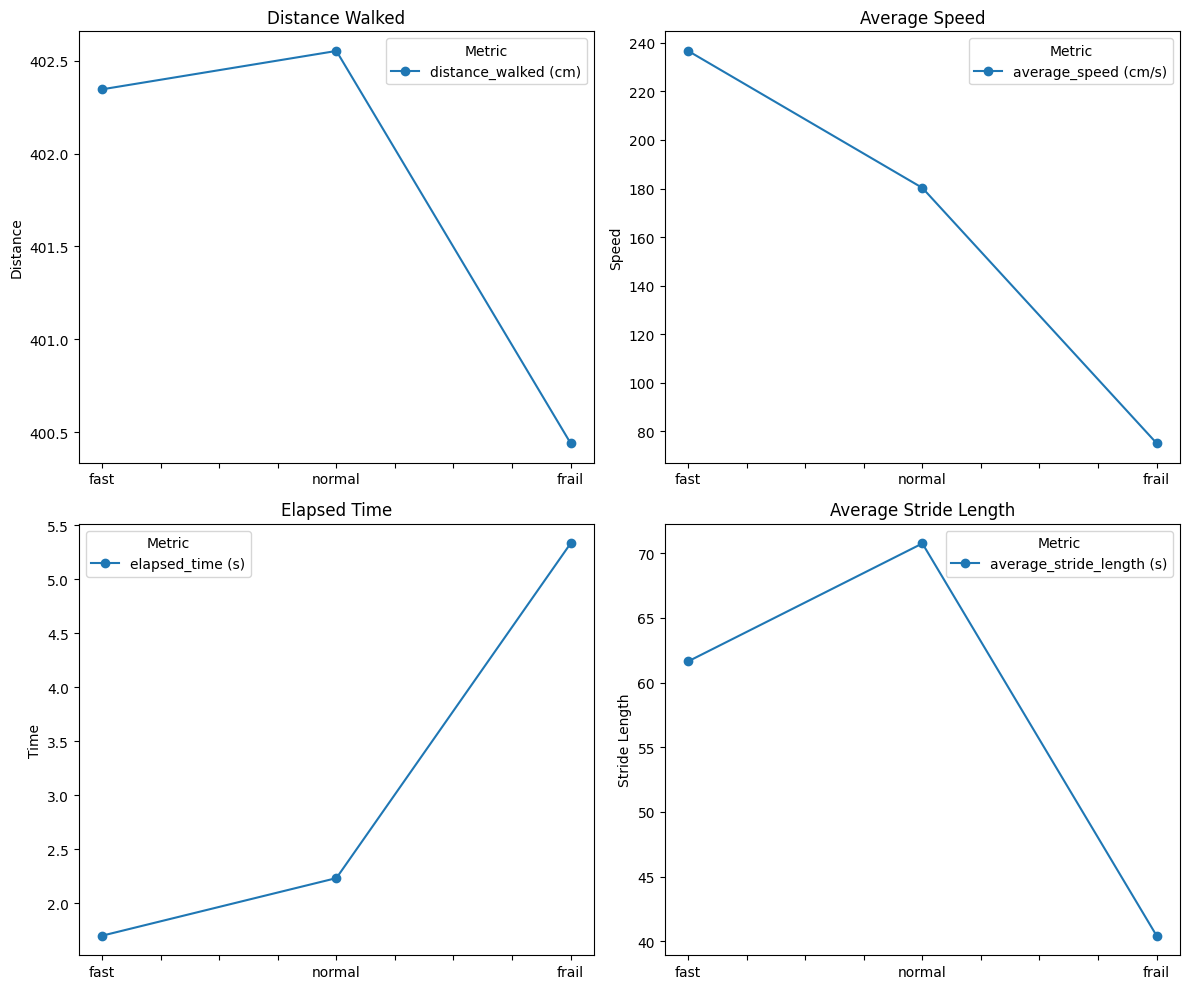

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "Metric": [
        "distance_walked (cm)",
        "average_speed (cm/s)",
        "elapsed_time (s)",
        "average_stride_length (s)",
    ],
    "fast": [
        fast_distance_walked,
        fast_average_speed,
        fast_elapsed_time,
        fast_average_stride_length,
    ],
    "normal": [
        normal_distance_walked,
        normal_average_speed,
        normal_elapsed_time,
        normal_average_stride_length,
    ],
    "frail": [
        frail_distance_walked,
        frail_average_speed,
        frail_elapsed_time,
        frail_average_stride_length,
    ],
}

# Create the DataFrame
df = pd.DataFrame(data)
print(df)

# Plotting the data as separate line charts for better visualization
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# First subplot for distance walked
df.set_index('Metric').T[['distance_walked (cm)']].plot(kind='line', marker='o', ax=axs[0, 0])
axs[0, 0].set_title("Distance Walked")
axs[0, 0].set_ylabel("Distance")

# Second subplot for average speed
df.set_index('Metric').T[['average_speed (cm/s)']].plot(kind='line', marker='o', ax=axs[0, 1])
axs[0, 1].set_title("Average Speed")
axs[0, 1].set_ylabel("Speed")

# Third subplot for elapsed time
df.set_index('Metric').T[['elapsed_time (s)']].plot(kind='line', marker='o', ax=axs[1, 0])
axs[1, 0].set_title("Elapsed Time")
axs[1, 0].set_ylabel("Time")

# Fourth subplot for average stride length
df.set_index('Metric').T[['average_stride_length (s)']].plot(kind='line', marker='o', ax=axs[1, 1])
axs[1, 1].set_title("Average Stride Length")
axs[1, 1].set_ylabel("Stride Length")

plt.tight_layout()
plt.show()


            Metric                   Type        fast     normal      frail
0             NOSE            Motion Mean   26.308361  22.128073   9.317410
1             NOSE             Motion Std    6.440182   5.878313   5.694792
2             NOSE  Angular Circular Mean    0.009757   0.055238  -0.059033
3             NOSE   Angular Circular Std    0.184352   0.192818   0.270934
4    LEFT_SHOULDER            Motion Mean   26.198414  22.734777   9.754792
5    LEFT_SHOULDER             Motion Std    7.609619   9.322408   5.033658
6    LEFT_SHOULDER  Angular Circular Mean   -0.002377  -0.033205  -0.033009
7    LEFT_SHOULDER   Angular Circular Std    0.180962   0.179326   0.229651
8   RIGHT_SHOULDER            Motion Mean   30.785024  23.072623   9.268749
9   RIGHT_SHOULDER             Motion Std   16.304708   6.134419   2.965169
10  RIGHT_SHOULDER  Angular Circular Mean    0.090708   0.019346  -0.015002
11  RIGHT_SHOULDER   Angular Circular Std    0.313737   0.140915   0.173669
12        LE

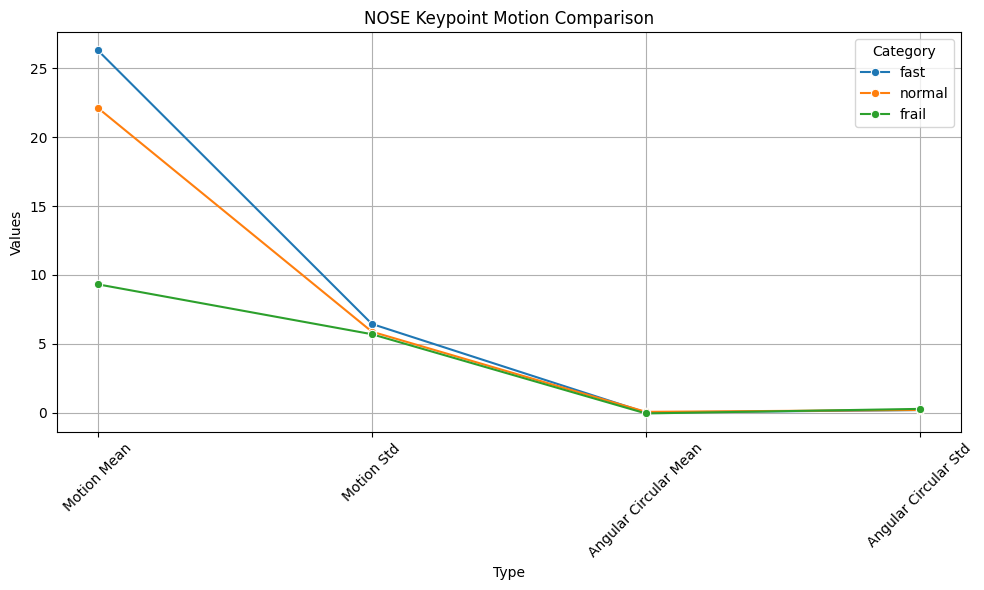

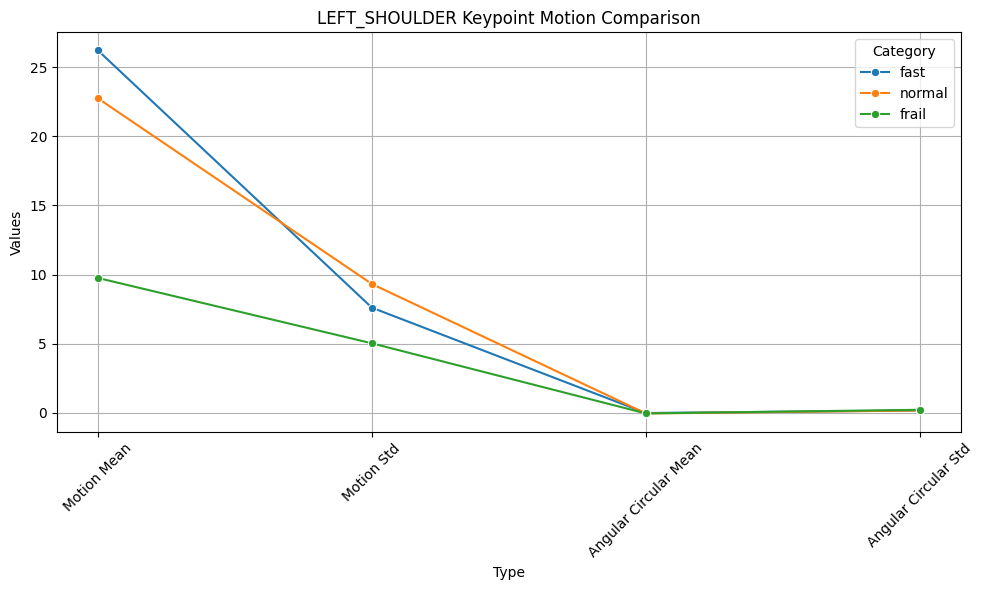

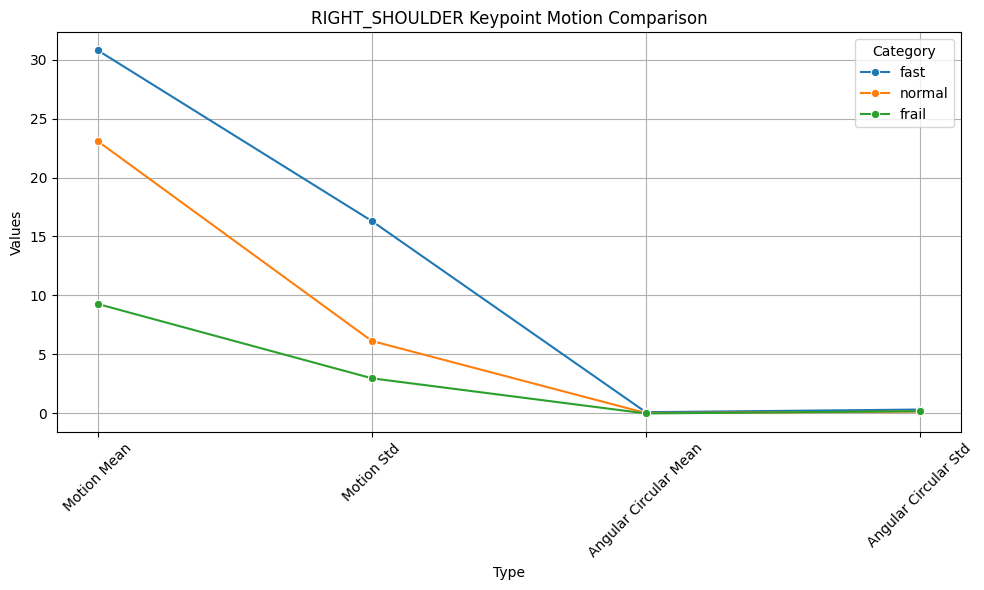

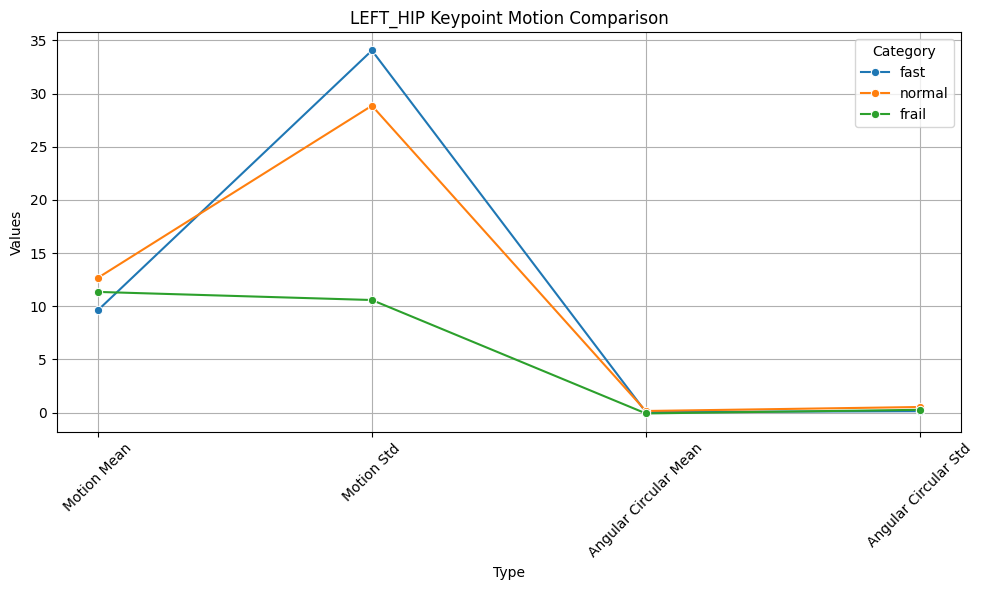

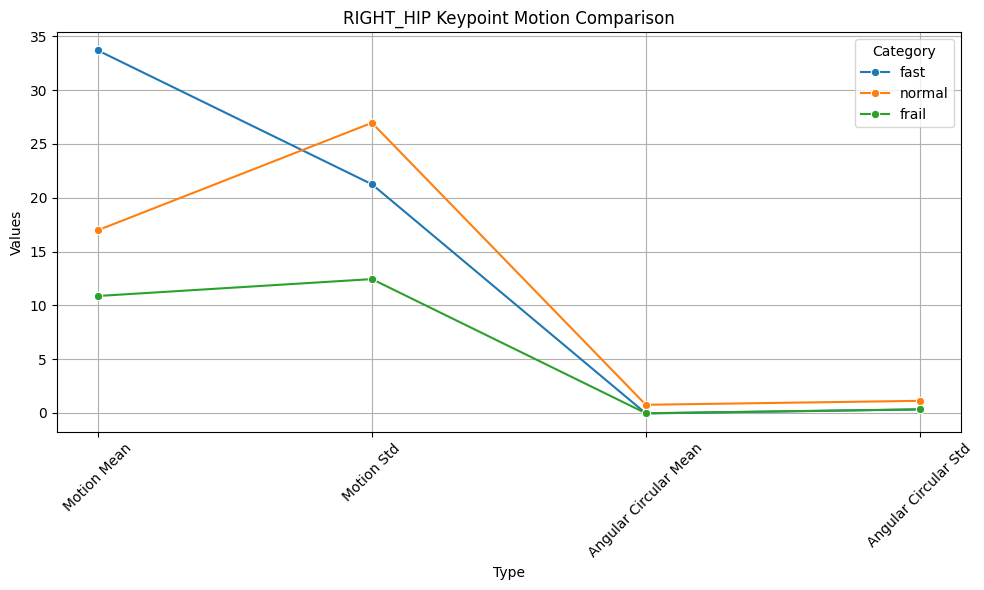

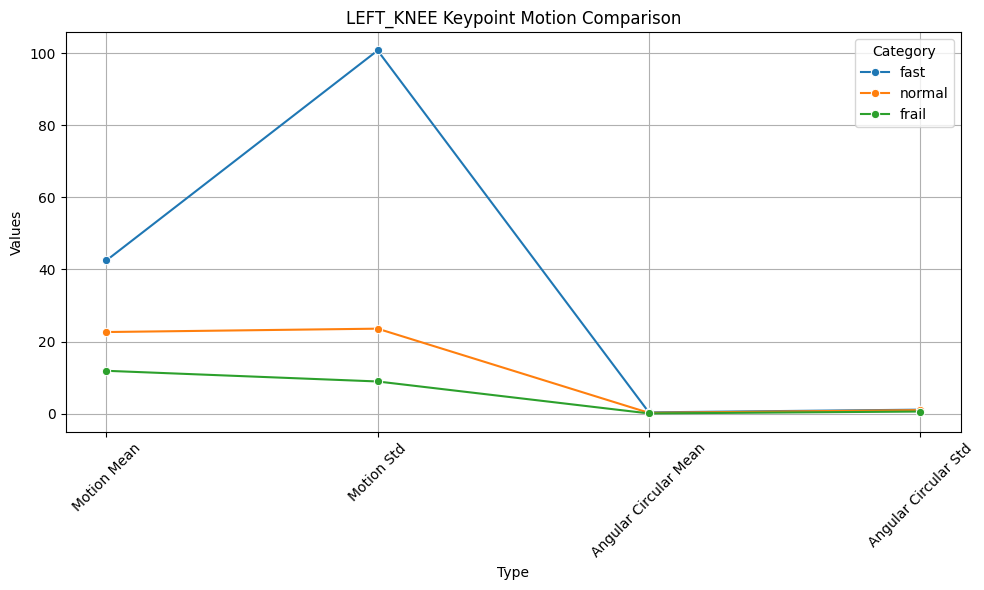

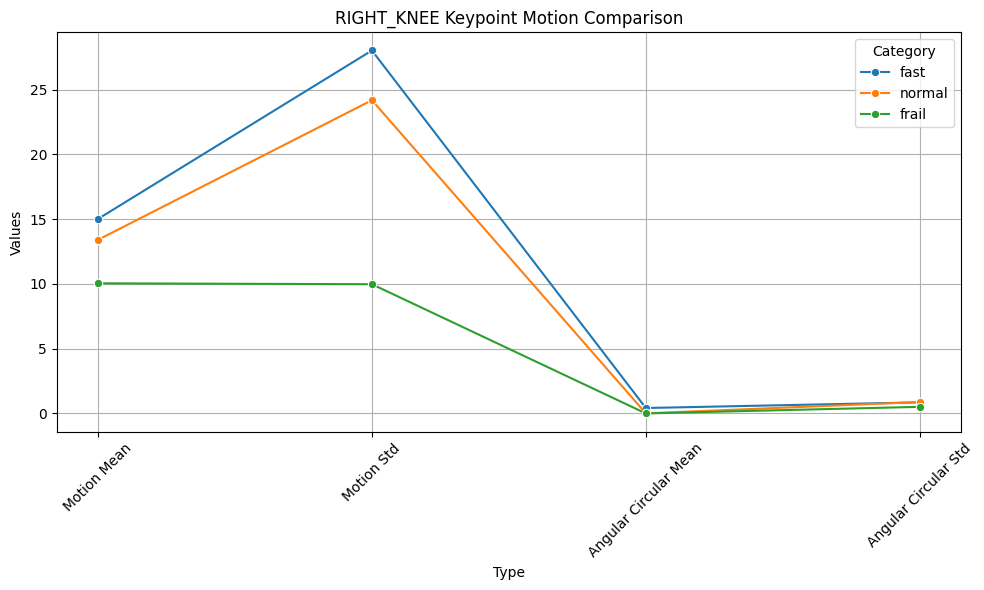

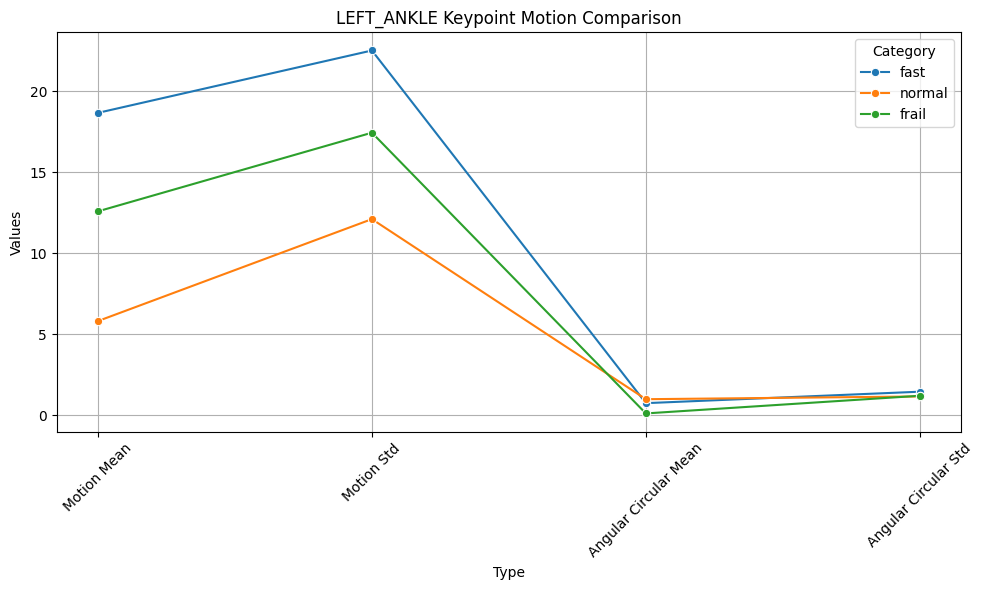

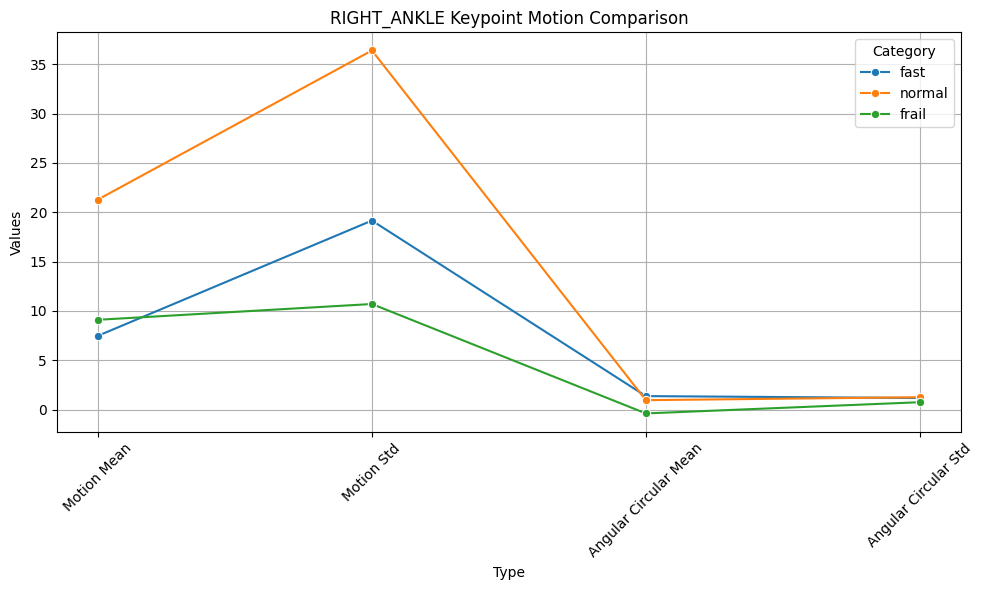

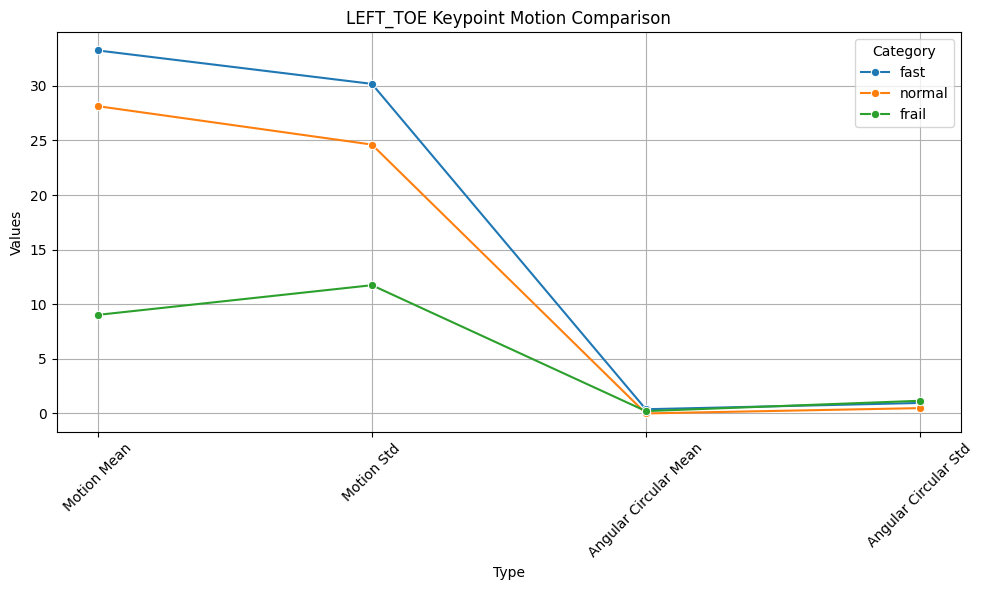

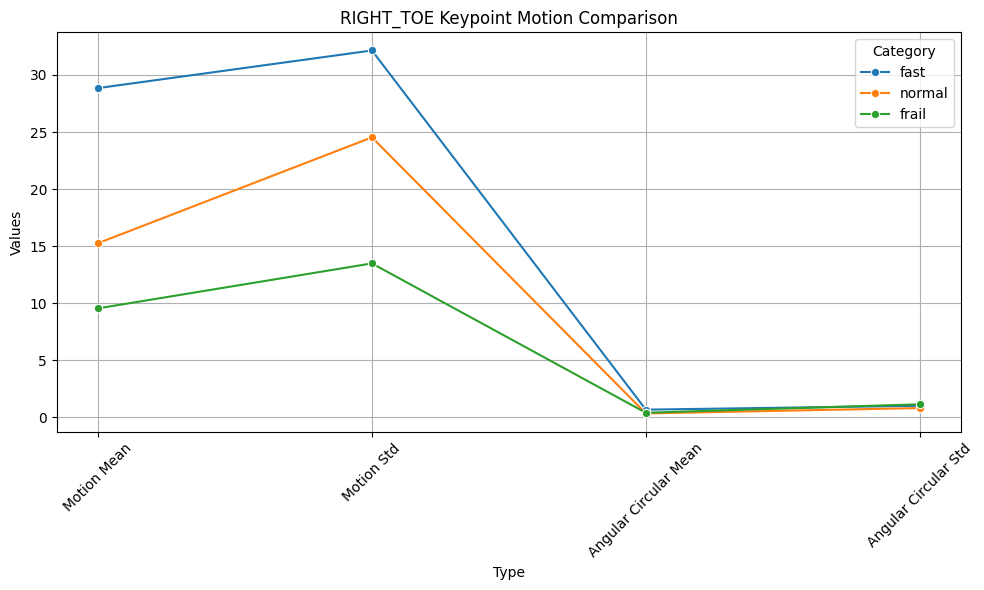

In [12]:
# mean and std of keypoints
keypoint_data = {
    "fast": {
        "motion_mean_magnitudes": fast_keypoint_mean_magnitudes,
        "motion_std_devs": fast_keypoint_std_devs,
        "circular_mean": fast_keypoint_circular_mean,
        "circular_std": fast_keypoint_circular_std
    },
    "normal": {
        "motion_mean_magnitudes": normal_keypoint_mean_magnitudes,
        "motion_std_devs": normal_keypoint_std_devs,
        "circular_mean": normal_keypoint_circular_mean,
        "circular_std": normal_keypoint_circular_std
        
    },
    "frail": {
        "motion_mean_magnitudes": frail_keypoint_mean_magnitudes,
        "motion_std_devs": frail_keypoint_std_devs,
        "circular_mean": frail_keypoint_circular_mean,
        "circular_std": frail_keypoint_circular_std
    }
}

# rows are the keypoints
keypoints = list(fast_keypoint_mean_magnitudes.keys()) 


metrics = []
types = []
fast_values = []
normal_values = []
frail_values = []

# Loop through keypoints and populate data for both mean and std types
for keypoint in keypoints:
    # Populate mean magnitudes
    metrics.append(keypoint)
    types.append('Motion Mean')
    fast_values.append(fast_keypoint_mean_magnitudes[keypoint])
    normal_values.append(normal_keypoint_mean_magnitudes[keypoint])
    frail_values.append(frail_keypoint_mean_magnitudes[keypoint])
    
    # Populate std deviations
    metrics.append(keypoint)
    types.append('Motion Std')
    fast_values.append(fast_keypoint_std_devs[keypoint])
    normal_values.append(normal_keypoint_std_devs[keypoint])
    frail_values.append(frail_keypoint_std_devs[keypoint])
    
    metrics.append(keypoint)
    types.append('Angular Circular Mean')
    fast_values.append(fast_keypoint_circular_mean[keypoint])
    normal_values.append(normal_keypoint_circular_mean[keypoint])
    frail_values.append(frail_keypoint_circular_mean[keypoint])
    
    # Populate std deviations
    metrics.append(keypoint)
    types.append('Angular Circular Std')
    fast_values.append(fast_keypoint_circular_std[keypoint])
    normal_values.append(normal_keypoint_circular_std[keypoint])
    frail_values.append(frail_keypoint_circular_std[keypoint])

# Create the DataFrame
df = pd.DataFrame({
    "Metric": metrics,
    "Type": types,
    "fast": fast_values,
    "normal": normal_values,
    "frail": frail_values,
    
})

# Display the DataFrame
print(df)

# Visualizing the keypoint data for LEFT_TOE as an example
import seaborn as sns

keypoints

import seaborn as sns
import matplotlib.pyplot as plt

# Loop through each keypoint and generate a plot
for keypoint in keypoints:
    # Filter the dataframe for the specific keypoint
    keypoint_df = df[df["Metric"] == keypoint]
    
    # Convert the DataFrame to long format for Seaborn
    keypoint_long = pd.melt(keypoint_df, id_vars=["Type"], value_vars=["fast", "normal", "frail"], 
                            var_name="Category", value_name="Value")
    
    # Plot the data using a line chart for each type of motion
    plt.figure(figsize=(10, 6))
    
    # Create a line plot for each type: Motion Mean, Motion Std, Angular Circular Mean, and Angular Circular Std
    sns.lineplot(data=keypoint_long, x="Type", y="Value", hue="Category", marker="o")
    
    # Add labels and title
    plt.title(f"{keypoint} Keypoint Motion Comparison")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()



In [28]:
# print(np.sum(strides))
# print(np.mean(strides))
# print(strides)
# print(keypoints_over_time)


In [39]:
# Test
keypoint_mean_magnitudes = {
    keypoint: sum(frame[keypoint][0] for frame in keypoints_over_time) / len(keypoints_over_time)
    for keypoint in keypoints_over_time[0]
}
keypoint_mean_magnitudes

keypoint_std_devs = {
    keypoint: np.std([frame[keypoint][0] for frame in keypoints_over_time])
    for keypoint in keypoints_over_time[0]
}
keypoint_std_devs

keypoint_circular_mean = {
    keypoint: circmean([frame[keypoint][1] for frame in keypoints_over_time], high=np.pi, low=-np.pi)
    for keypoint in keypoints_over_time[0]
}
keypoint_circular_mean
keypoint_circular_std = {
    keypoint: circstd([frame[keypoint][1] for frame in keypoints_over_time], high=np.pi, low=-np.pi)
    for keypoint in keypoints_over_time[0]
}
keypoint_circular_mean

{'NOSE': 8.636831855416904,
 'LEFT_SHOULDER': 8.843134312734232,
 'RIGHT_SHOULDER': 9.183666403631802,
 'LEFT_HIP': 11.982630119492336,
 'RIGHT_HIP': 12.462033693055904,
 'LEFT_KNEE': 11.620708724032708,
 'RIGHT_KNEE': 10.175156150045243,
 'LEFT_ANKLE': 9.473088104654941,
 'RIGHT_ANKLE': 8.802806491858941,
 'LEFT_TOE': 9.013240970624864,
 'RIGHT_TOE': 9.048048408904508}

{'NOSE': 2.230428126939115,
 'LEFT_SHOULDER': 5.8010901769254515,
 'RIGHT_SHOULDER': 3.1031788748213653,
 'LEFT_HIP': 38.35678442440704,
 'RIGHT_HIP': 28.56056547101388,
 'LEFT_KNEE': 16.54074007986616,
 'RIGHT_KNEE': 22.401926619695573,
 'LEFT_ANKLE': 17.87737062621513,
 'RIGHT_ANKLE': 11.553112441300568,
 'LEFT_TOE': 14.392459514154032,
 'RIGHT_TOE': 16.244664606165376}

{'NOSE': 0.3631894553997381,
 'LEFT_SHOULDER': 0.302306531264533,
 'RIGHT_SHOULDER': 0.30263813670437445,
 'LEFT_HIP': 1.5985171688158193,
 'RIGHT_HIP': 0.34040817901386067,
 'LEFT_KNEE': 0.5664917103915732,
 'RIGHT_KNEE': 1.706916554318732,
 'LEFT_ANKLE': 2.1972539201070136,
 'RIGHT_ANKLE': 2.3791539930498313,
 'LEFT_TOE': 1.3726208272291496,
 'RIGHT_TOE': 2.2084774067772353}

In [21]:

# Profile the test
import pstats
person_height = 175  # Example height in meters
video_path = "/Users/brennanlee/Desktop/opencv-healthcare/test/GSWT_normal_youlian.mp4"
cProfile.run('process_gswt(video_path, person_height, 400, debug=False)')

p1 = pstats.Stats('process_gswt_python.prof')
print(p1.strip_dirs().sort_stats(-1).print_stats())

2024-09-24 21:49:30,648 - INFO - Starting video processing
2024-09-24 21:49:31,451 - INFO - ===================== Processing frame 1 ==================================
2024-09-24 21:49:31,452 - INFO - Central ankle point: (0.07960475236177444, 0.9299815595149994)
2024-09-24 21:49:31,452 - INFO - Pixels to cm ratio: 7.24529003415789 is set
2024-09-24 21:49:31,453 - INFO - Central point: (0.10030108317732811, 0.6422167420387268)
2024-09-24 21:49:31,454 - INFO - Ground line set at Y: 1.0099815595149995
2024-09-24 21:49:31,455 - INFO - Waiting for the person to start walking
2024-09-24 21:49:31,456 - INFO - Right foot slope: 0.5214084843402751
2024-09-24 21:49:31,456 - INFO - Initial foot slope: 0.5214084843402751
2024-09-24 21:49:31,533 - INFO - ===================== Processing frame 2 ==================================
2024-09-24 21:49:31,534 - INFO - Central ankle point: (0.08000633865594864, 0.9292741417884827)
2024-09-24 21:49:31,535 - INFO - Central point: (0.10060486197471619, 0.643

         1148309 function calls (1134977 primitive calls) in 21.960 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.378    1.378   21.960   21.960 1673506304.py:1(process_gswt)
        1    0.000    0.000    0.001    0.001 1673506304.py:371(<dictcomp>)
     1474    0.001    0.000    0.001    0.000 1673506304.py:372(<genexpr>)
        1    0.000    0.000    0.001    0.001 1673506304.py:375(<dictcomp>)
       11    0.000    0.000    0.000    0.000 1673506304.py:376(<listcomp>)
        1    0.000    0.000    0.007    0.007 1673506304.py:379(<dictcomp>)
       11    0.000    0.000    0.000    0.000 1673506304.py:380(<listcomp>)
        1    0.000    0.000    0.008    0.008 1673506304.py:383(<dictcomp>)
       11    0.000    0.000    0.000    0.000 1673506304.py:384(<listcomp>)
      202    0.002    0.000    0.002    0.000 1673506304.py:76(<listcomp>)
      139    0.000    0.000    0.000    0.000 1861477174.py:16(

FileNotFoundError: [Errno 2] No such file or directory: 'process_gswt_python.prof'

In [15]:
# profiling Python vs Cython

import cProfile
import pstats
import gait_speed_walk_overall

cProfile.run('gait_speed_walk_overall.process_test(video_path, person_height, 400, False)', 'gait_speed_walk_overall_cython.prof')

p2 = pstats.Stats('gait_speed_walk_overall_cython.prof')
print(p2.strip_dirs().sort_stats(-1).print_stats())

2024-09-24 21:46:51,725 - INFO - Starting video processing
2024-09-24 21:46:52,340 - INFO - ===================== Processing frame 1 ==================================
2024-09-24 21:46:52,341 - INFO - --- Misc --- 
2024-09-24 21:46:52,343 - INFO - Central ankle point: (0.07960475236177444, 0.9299815595149994)
2024-09-24 21:46:52,344 - INFO - Pixels to cm ratio: 7.24529003415789 is set
2024-09-24 21:46:52,345 - INFO - Central point: (0.10030108317732811, 0.6422167420387268)
2024-09-24 21:46:52,345 - INFO - --- End of Misc ---
2024-09-24 21:46:52,346 - INFO - Waiting for the person to start walking
2024-09-24 21:46:52,347 - INFO - --- Optical Flow ---
2024-09-24 21:46:52,348 - INFO - --- End of Optical Flow ---
2024-09-24 21:46:52,348 - INFO - --- Foot & Stride Information ---
2024-09-24 21:46:52,349 - INFO - Foot slope: 0.5214084843402751
2024-09-24 21:46:52,350 - INFO - Initial foot slope: 0.5214084843402751
2024-09-24 21:46:52,351 - INFO - --- End of Foot & Stride Information ---
2024

Tue Sep 24 21:47:15 2024    gait_speed_walk_overall_cython.prof

         1298737 function calls (1285405 primitive calls) in 12.857 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       44    0.000    0.000    0.000    0.000 <string>:1(<lambda>)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
     4012    0.021    0.000    2.633    0.001 __init__.py:1077(flush)
     4012    0.017    0.000    3.396    0.001 __init__.py:1088(emit)
     4012    0.006    0.000    0.007    0.000 __init__.py:119(getLevelName)
     4012    0.015    0.000    3.679    0.001 __init__.py:1467(info)
     4012    0.028    0.000    0.046    0.000 __init__.py:1549(findCaller)
     4012    0.010    0.000    0.148    0.000 __init__.py:1585(makeRecord)
     4012    0.005    0.000    0.007    0.000 __init__.py:160(<lambda>)
     4012    0.016    0.000    3.659    0.001 __init__.py:1600(_log)
     4012    0.008    0.000    3.449    0.001 _

In [11]:
# Black mask

person_height = 175  # Example height in meters

def process_gswt(
    video_path,
    person_height_in_cm,
    distance_required_in_cm,
    movement_threshold=0.02,
    debug=True,
):
    logging.info("Starting video processing")

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps == 0:
        logging.error("Cannot determine the frame rate (FPS) of the video.")
        return 0, 0, 0  # Default values for stride length, elapsed time, and speed

    start_frame_id = None
    end_frame_id = None
    start_position = None
    distance_walked = 0
    timer_started = False
    strides = []
    
    central_point = None

    pixels_to_cm_ratio = None
    start_line = None
    is_start_line_set = False
    ground_line = None

    ground_threshold = 0.08
    start_line_offset = 0.01

    previous_gray = None
    previous_keypoints = None
    foot_contact_start = False  # Flag to track first contact
    foot_off_ground = False  # Flag to track if foot is lifted off ground
    reset_needed = False  # Flag to reset after stride is recorded
    initial_foot_slope = None  # Initial slope of the foot
    keypoints_over_time = []

    frame_counter = 0
    confirm_frames = 5
    

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            logging.warning("End of video or cannot read the video file")
            break

        black_mask = np.zeros_like(frame)
        current_frame_id = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        current_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        logging.info(
            f"===================== Processing frame {current_frame_id} =================================="
        )
        if results.pose_landmarks:
            # Draw pose landmarks
            if debug:
                mp_drawing.draw_landmarks(
                        black_mask,
                        results.pose_landmarks,
                        mp_pose.POSE_CONNECTIONS,
                        mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                        mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2),
                    )
            
            landmarks = results.pose_landmarks.landmark
            
            keypoints = get_keypoints(landmarks)
            
            keypoint_array = np.array(
                [[kp.x * frame.shape[1], kp.y * frame.shape[0]] for kp in keypoints.values()],
                dtype=np.float32
            ).reshape(-1, 1, 2)

            central_ankle = calculate_central_point(keypoints["LEFT_ANKLE"], keypoints["RIGHT_ANKLE"])
            logging.info(f"Central ankle point: {central_ankle}")

            # Calculate the height of the person in px
            estimated_height_in_px = calculate_vertical_distance(keypoints["NOSE"], central_ankle, frame.shape[0])   # Possibly add a offset to the height

            if pixels_to_cm_ratio is None:
                pixels_to_cm_ratio = estimated_height_in_px / person_height_in_cm
                logging.info(f"Pixels to cm ratio: {pixels_to_cm_ratio} is set")

            # Fix central point of the person using hip points
            central_point = calculate_central_point(keypoints["LEFT_HIP"], keypoints["RIGHT_HIP"])
            logging.info(f"Central point: {central_point}")

            if ground_line is None:
                # Set the ground line slightly below the ankle
                ground_line = central_ankle.y + ground_threshold
                logging.info(f"Ground line set at Y: {ground_line}")
            else:
                if debug:
                    cv2.line(
                        frame,
                        (0, int(ground_line * frame.shape[0])),
                        (frame.shape[1], int(ground_line * frame.shape[0])),
                        (0, 255, 0),  # Green color for the ground line
                        50,
                    )

            if start_position is None and central_point is not None and not is_start_line_set:
                # Set start line slightly in front of the initial frontmost toe
                frame_counter+=1
                if frame_counter >= confirm_frames:
                    is_start_line_set = True
                    start_line = max(keypoints["LEFT_TOE"].x, keypoints["RIGHT_TOE"].x) + start_line_offset
                    logging.info(f"Start line set at X: {start_line}")

            # Draw the start line
            if debug and is_start_line_set:
                # Convert normalized start line X position to pixel coordinates
                start_line_pixel_x = int(start_line * frame.shape[1])

                cv2.line(
                    black_mask,
                    (start_line_pixel_x, 0),
                    (start_line_pixel_x, frame.shape[0]),
                    (255, 0, 0),  # Blue color for the start line
                    2,
                )

            if not timer_started and is_start_line_set:
                # Check if either toe crosses the start line
                if max(keypoints["LEFT_TOE"].x, keypoints["RIGHT_TOE"].x) >= start_line:
                    start_position = central_point
                    start_frame_id = current_frame_id
                    timer_started = True
                    logging.info(f"Timer started at frame {start_frame_id}")

            # Main Processing only when the timer has started
            if timer_started:
                distance_walked = (
                    calculate_horizontal_distance(start_position, central_point, frame.shape[1])
                    / pixels_to_cm_ratio
                )
                logging.info(f"Distance walked: {distance_walked} cm")

                # End processing
                if distance_walked >= distance_required_in_cm:
                    end_frame_id = current_frame_id
                    logging.info(
                        f"Distance: {distance_required_in_cm} cm is completed - {distance_walked} cm"
                    )
                    break
                
                
                
            # Display timer and distance
            if timer_started and start_frame_id is not None:
                elapsed_time = (current_frame_id - start_frame_id) / fps
                if end_frame_id is not None:
                    distance_walked = (
                        calculate_horizontal_distance(start_position, central_point, frame.shape[1])
                        / pixels_to_cm_ratio
                    )
                    elapsed_time = (end_frame_id - start_frame_id) / fps
                if debug:
                    cv2.putText(
                        frame,
                        f"Time: {elapsed_time:.2f} sec",
                        (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1,
                        (0, 255, 0),
                        2,
                        cv2.LINE_AA,
                    )
                    cv2.putText(
                        frame,
                        f"Distance: {distance_walked:.2f} cm",
                        (10, 70),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1,
                        (0, 255, 0),
                        2,
                        cv2.LINE_AA,
                    )
            else:
                if debug:
                    cv2.putText(
                        frame,
                        f"Timer not started",
                        (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1,
                        (0, 0, 255),
                        2,
                        cv2.LINE_AA,
                    )
            
            if not timer_started and start_position is None:
                logging.info("Waiting for the person to start walking")

            # Calculate motion vectors using optical flow
            if timer_started and previous_gray is not None and previous_keypoints is not None:
                p1, st, err = cv2.calcOpticalFlowPyrLK(
                    previous_gray, current_gray, previous_keypoints, None
                )
                
                current_frame_keypoints = {}

                for i, (new, old) in enumerate(zip(p1, previous_keypoints)):
                    new_x, new_y = new.ravel()
                    old_x, old_y = old.ravel()

                    motion_magnitude = np.sqrt((new_x - old_x) ** 2 + (new_y - old_y) ** 2)
                    motion_angle = np.arctan2(new_y - old_y, new_x - old_x)

                    key = list(keypoints.keys())[i]
                    current_frame_keypoints[key] = (motion_magnitude, motion_angle)
                    logging.info(
                        f"{key} - Magnitude: {motion_magnitude}, Angle: {motion_angle} radians"
                    )

                    # Optionally, visualize the motion (debugging)
                    if debug:
                        cv2.arrowedLine(
                            frame,
                            (int(old_x), int(old_y)),
                            (int(new_x), int(new_y)),
                            (0, 255, 0),
                            2,
                            tipLength=0.5
                        )
                keypoints_over_time.append(current_frame_keypoints)
                previous_keypoints = p1
            else:
                previous_keypoints = keypoint_array
            
            previous_gray = current_gray
            
            
            if initial_foot_slope is None:
                initial_foot_slope = calculate_foot_slope(keypoints["RIGHT_ANKLE"], keypoints["RIGHT_TOE"])
                right_slope = initial_foot_slope
                logging.info(f"Initial foot slope: {initial_foot_slope}")
            else:
                right_slope = calculate_foot_slope(keypoints["RIGHT_ANKLE"], keypoints["RIGHT_TOE"])
                logging.info(f"Right foot slope: {right_slope}")
            
            # Detect foot contact with the ground
            if abs(right_slope) < initial_foot_slope:
                logging.info(f"Right foot is parallel to the ground")
                if not foot_contact_start and not reset_needed:
                    # First ground contact
                    foot_contact_start = True
                    foot_off_ground = False
                    initial_contact_position = keypoints["RIGHT_TOE"]
                    logging.info("First ground contact detected")

                elif foot_off_ground and reset_needed:
                    # Second ground contact, calculate stride
                    final_contact_position = keypoints["RIGHT_TOE"]
                    stride_length = (
                        calculate_horizontal_distance(
                            final_contact_position, initial_contact_position, frame.shape[1]
                        )
                        / pixels_to_cm_ratio
                    )
                    strides.append(stride_length)
                    logging.info(f"Stride length recorded: {stride_length} cm")

                    # Reset flags for the next stride detection
                    reset_needed = False
                    foot_contact_start = False
                    foot_off_ground = False
                    initial_contact_position = keypoints["RIGHT_TOE"]
            else:
                # Foot off ground
                if foot_contact_start and not reset_needed:
                    foot_off_ground = True
                    logging.info("Foot is off the ground")

                    # Allow reset to detect the next stride
                    reset_needed = True

            if debug:
                cv2.putText(
                    frame,
                    f"Right foot slope: {right_slope}",
                    (10, 90),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (255, 255, 0),
                    2,
                    cv2.LINE_AA,
                )
                cv2.putText(
                    frame,
                    f"Foot touching ground: {'YES' if foot_contact_start and abs(right_slope) < 0.9 else 'NO'}",
                    (10, 120),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (255, 255, 0),  # Yellow text for stride count
                    2,
                    cv2.LINE_AA,
                )
        if debug:
            # Display the frame
            cv2.imshow("Frame", black_mask)
            if cv2.waitKey(5) & 0xFF == 27:
                logging.info("Process interrupted by user")
                break
    
    cap.release()
    cv2.destroyAllWindows()
    logging.info("================================= Post Processing =================================")
    if strides:
        average_stride_length = np.mean(strides)
        logging.info(f"strides: {strides}")
        logging.info(f"Average stride length: {average_stride_length} cm")
        strides_per_second = len(strides) / elapsed_time if elapsed_time > 0 else 0
        logging.info(f"Strides per second: {strides_per_second}")
    else:
        average_stride_length = 0
        logging.info("No strides detected")
    
    
    
    # def ema(data, alpha=0.3):
    #     ema_result = [data[0]]  # Start with the first value
    #     for i in range(1, len(data)):
    #         ema_result.append(alpha * data[i] + (1 - alpha) * ema_result[i-1])
    #     return ema_result
    # if keypoints_over_time:
    #     keypoint_mean_magnitudes = {
    #         keypoint: sum(ema([frame[keypoint][0] for frame in keypoints_over_time])) / len(keypoints_over_time)
    #         for keypoint in keypoints_over_time[0]
    #     }
    #     keypoint_std_devs = {
    #         keypoint: np.std(ema([frame[keypoint][0] for frame in keypoints_over_time]))
    #         for keypoint in keypoints_over_time[0]
    #     }
    #     keypoint_circular_mean = {
    #         keypoint: circmean(ema([frame[keypoint][1] for frame in keypoints_over_time]), high=np.pi, low=-np.pi)
    #         for keypoint in keypoints_over_time[0]
    #     }
    #     keypoint_circular_std = {
    #         keypoint: circstd(ema([frame[keypoint][1] for frame in keypoints_over_time]), high=np.pi, low=-np.pi)
    #         for keypoint in keypoints_over_time[0]
    #     }
    
    # def moving_average(data, window_size=5):
    #     return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    # if keypoints_over_time:
    #     keypoint_mean_magnitudes = {
    #         keypoint: sum(moving_average([frame[keypoint][0] for frame in keypoints_over_time])) / len(keypoints_over_time)
    #         for keypoint in keypoints_over_time[0]
    #     }
    #     keypoint_std_devs = {
    #         keypoint: np.std(moving_average([frame[keypoint][0] for frame in keypoints_over_time]))
    #         for keypoint in keypoints_over_time[0]
    #     }
    #     keypoint_circular_mean = {
    #         keypoint: circmean(moving_average([frame[keypoint][1] for frame in keypoints_over_time]), high=np.pi, low=-np.pi)
    #         for keypoint in keypoints_over_time[0]
    #     }
    #     keypoint_circular_std = {
    #         keypoint: circstd(moving_average([frame[keypoint][1] for frame in keypoints_over_time]), high=np.pi, low=-np.pi)
    #         for keypoint in keypoints_over_time[0]
    #     }
    # no filter version
    if keypoints_over_time:
        keypoint_mean_magnitudes = {
            keypoint: sum(frame[keypoint][0] for frame in keypoints_over_time) / len(keypoints_over_time)
            for keypoint in keypoints_over_time[0]
        }
        keypoint_std_devs = {
            keypoint: np.std([frame[keypoint][0] for frame in keypoints_over_time])
            for keypoint in keypoints_over_time[0]
        }
        keypoint_circular_mean = {
            keypoint: circmean([frame[keypoint][1] for frame in keypoints_over_time], high=np.pi, low=-np.pi)
            for keypoint in keypoints_over_time[0]
        }
        keypoint_circular_std = {
            keypoint: circstd([frame[keypoint][1] for frame in keypoints_over_time], high=np.pi, low=-np.pi)
            for keypoint in keypoints_over_time[0]
        }
        
    else:
        keypoint_std_devs = -1
        keypoint_mean_magnitudes = -1
        logging.info("No keypoints detected")
        

    if timer_started and start_frame_id is not None:
        elapsed_time = (current_frame_id - start_frame_id) / fps
        logging.info(f"Elapsed time: {elapsed_time} seconds")
        average_speed = distance_walked / elapsed_time if elapsed_time > 0 else 0
        logging.info(f"Average speed: {average_speed} cm/second")
    else:
        elapsed_time = 0
        average_speed = 0
        logging.info("Problems detected, unable to calculate")

    return "Gait Speed Walk Test", distance_walked,elapsed_time, average_speed, average_stride_length, keypoint_mean_magnitudes, keypoint_std_devs, keypoint_circular_mean, keypoint_circular_std
# , keypoints_over_time


# video_path = "/Users/brennanlee/Desktop/opencv-healthcare/test/GSWT(forward).mp4"
video_path = "/Users/brennanlee/Desktop/opencv-healthcare/test/GSWT_normal_youlian.mp4"
# video_path = "/Users/brennanlee/Desktop/opencv-healthcare/test/GSWT_fast_youlian.mp4"
# video_path = "/Users/brennanlee/Desktop/opencv-healthcare/test/GSWT_frail_youlian.mp4"
# person_height = 175  # Example height in meters
test_name, distance_walked,elapsed_time, average_speed, average_stride_length, keypoint_mean_magnitudes, keypoint_std_devs, keypoint_circular_mean, keypoint_circular_std = process_gswt(
    video_path, person_height, 400
)
# , keypoints_over_time 




2024-09-26 01:53:42,459 - INFO - Starting video processing
2024-09-26 01:53:42,993 - INFO - ===================== Processing frame 1 ==================================
2024-09-26 01:53:42,996 - INFO - Central ankle point: (0.08004450052976608, 0.9288134574890137)
2024-09-26 01:53:42,997 - INFO - Pixels to cm ratio: 7.230334527151925 is set
2024-09-26 01:53:42,998 - INFO - Central point: (0.10068488866090775, 0.6452150046825409)
2024-09-26 01:53:42,999 - INFO - Ground line set at Y: 1.0088134574890137
2024-09-26 01:53:43,001 - INFO - Waiting for the person to start walking
2024-09-26 01:53:43,002 - INFO - Right foot slope: 0.8646785698068397
2024-09-26 01:53:43,002 - INFO - Initial foot slope: 0.8646785698068397
2024-09-26 01:53:43,346 - INFO - ===================== Processing frame 2 ==================================
2024-09-26 01:53:43,350 - INFO - Central ankle point: (0.08019525557756424, 0.9288312792778015)
2024-09-26 01:53:43,351 - INFO - Central point: (0.10100748762488365, 0.64

UnboundLocalError: local variable 'elapsed_time' referenced before assignment

: 

In [21]:
# Comparisons of 3 tests
video_path_frail = "/Users/brennanlee/Desktop/opencv-healthcare/test/GSWT_frail_youlian.mp4"
video_path_normal = "/Users/brennanlee/Desktop/opencv-healthcare/test/GSWT_normal_youlian.mp4"
video_path_fast = "/Users/brennanlee/Desktop/opencv-healthcare/test/GSWT_fast_youlian.mp4"

person_height = 175  # Example height
distance_required = 400  # Example distance in cm

# Process the frail test
test_name_frail, distance_walked_frail, elapsed_time_frail, average_speed_frail, average_stride_length_frail, keypoint_mean_magnitudes_frail, keypoint_std_devs_frail, keypoint_circular_mean_frail, keypoint_circular_std_frail = process_gswt(
    video_path_frail, person_height, distance_required
)

# Process the normal test
test_name_normal, distance_walked_normal, elapsed_time_normal, average_speed_normal, average_stride_length_normal, keypoint_mean_magnitudes_normal, keypoint_std_devs_normal, keypoint_circular_mean_normal, keypoint_circular_std_normal = process_gswt(
    video_path_normal, person_height, distance_required
)

# Process the fast test
test_name_fast, distance_walked_fast, elapsed_time_fast, average_speed_fast, average_stride_length_fast, keypoint_mean_magnitudes_fast, keypoint_std_devs_fast, keypoint_circular_mean_fast, keypoint_circular_std_fast = process_gswt(
    video_path_fast, person_height, distance_required
)

# Create a DataFrame to compare the results
data = {
    "Metric": [
        "distance_walked (cm)",
        "average_speed (cm/s)",
        "elapsed_time (s)",
        "average_stride_length (cm)",
    ],
    "Low": [
        distance_walked_fast,
        average_speed_fast,
        elapsed_time_fast,
        average_stride_length_fast,
    ],
    "Moderate": [
        distance_walked_normal,
        average_speed_normal,
        elapsed_time_normal,
        average_stride_length_normal,
    ],
    "High": [
        distance_walked_frail,
        average_speed_frail,
        elapsed_time_frail,
        average_stride_length_frail,
    ],
}



                       Metric         Low    Moderate        High
0        distance_walked (cm)  402.346437  402.553102  401.841882
1        average_speed (cm/s)  236.674375  180.247657   75.110632
2            elapsed_time (s)    1.700000    2.233333    5.350000
3  average_stride_length (cm)   61.643819   70.755733   51.790121


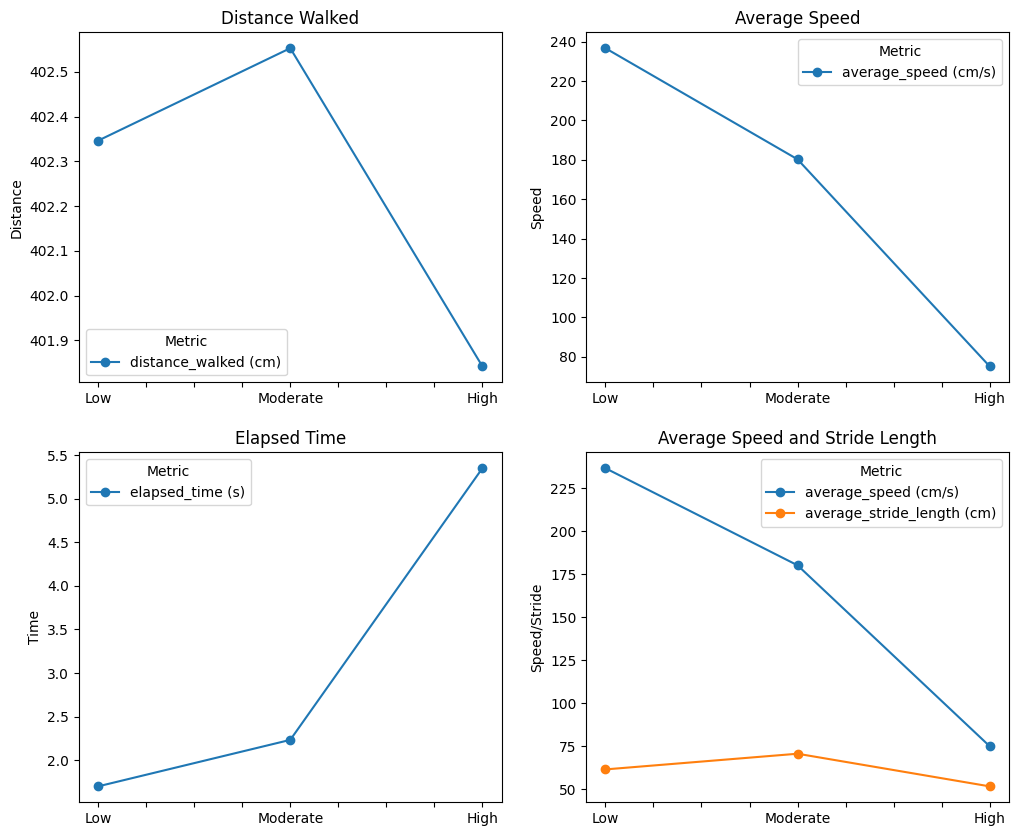

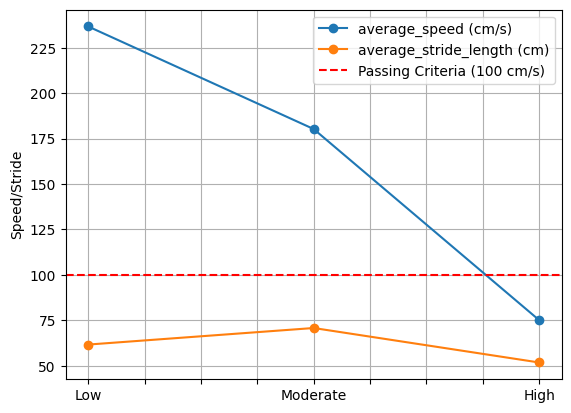

In [22]:
import pandas as pd
df = pd.DataFrame(data)
print(df)

# plot a graph of metres per second of each test
import matplotlib.pyplot as plt

# Plotting the data as separate line charts for better visualization
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# First subplot for distance walked
df.set_index('Metric').T[['distance_walked (cm)']].plot(kind='line', marker='o', ax=axs[0, 0])
axs[0, 0].set_title("Distance Walked")
axs[0, 0].set_ylabel("Distance")

# Second subplot for average speed
df.set_index('Metric').T[['average_speed (cm/s)']].plot(kind='line', marker='o', ax=axs[0, 1])
axs[0, 1].set_title("Average Speed")
axs[0, 1].set_ylabel("Speed")

# Third subplot for elapsed time
df.set_index('Metric').T[['elapsed_time (s)']].plot(kind='line', marker='o', ax=axs[1, 0])
axs[1, 0].set_title("Elapsed Time")
axs[1, 0].set_ylabel("Time")

# Combine the average stride length and average speed into a single plot
df.set_index('Metric').T[['average_speed (cm/s)', 'average_stride_length (cm)']].plot(kind='line', marker='o', ax=axs[1, 1])
axs[1, 1].set_title("Average Speed and Stride Length")
axs[1, 1].set_ylabel("Speed/Stride")

# i dont want subplots for stride length and the average speed
# Draw a line at the 100 cm/s mark for average speed to indicate passing criteria

df.set_index('Metric').T[['average_speed (cm/s)', 'average_stride_length (cm)']].plot(kind='line', marker='o')
plt.axhline(y=100, color='r', linestyle='--', label="Passing Criteria (100 cm/s)")
# plt.title("Average Speed and Stride Length")
plt.ylabel("Speed/Stride")
plt.grid(True)
plt.legend()
plt.show()


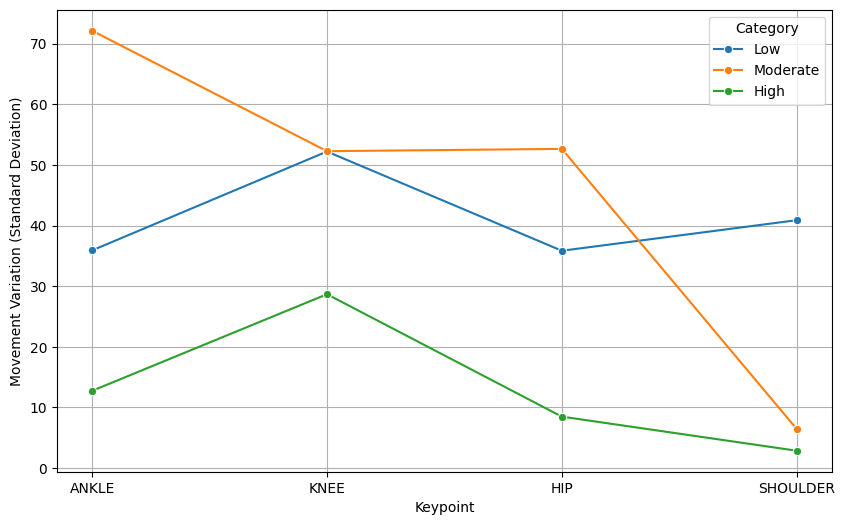

    Keypoint        Type  Category      Value
0      ANKLE  Motion Std       Low  35.900272
1       KNEE  Motion Std       Low  52.196433
2        HIP  Motion Std       Low  35.839633
3   SHOULDER  Motion Std       Low  40.874424
4      ANKLE  Motion Std  Moderate  72.109562
5       KNEE  Motion Std  Moderate  52.252540
6        HIP  Motion Std  Moderate  52.631925
7   SHOULDER  Motion Std  Moderate   6.459454
8      ANKLE  Motion Std      High  12.750112
9       KNEE  Motion Std      High  28.673405
10       HIP  Motion Std      High   8.493918
11  SHOULDER  Motion Std      High   2.873608


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define the keypoint names to compare, and remove the 'RIGHT_' prefix
keypoints = ["ANKLE", "KNEE", "HIP", "SHOULDER"]

# Assuming you have already computed the std_devs for each category (fast, normal, frail)
# Replace keypoint_std_devs_fast, keypoint_std_devs_normal, and keypoint_std_devs_frail with your actual data
keypoint_motion_std_fast = [keypoint_std_devs_fast[f'RIGHT_{keypoint}'] for keypoint in keypoints]
keypoint_motion_std_normal = [keypoint_std_devs_normal[f'RIGHT_{keypoint}'] for keypoint in keypoints]
keypoint_motion_std_frail = [keypoint_std_devs_frail[f'RIGHT_{keypoint}'] for keypoint in keypoints]

# add 40 to shoulder of normal only
# keypoint_motion_std_normal[3] += 40



# Create a DataFrame for plotting
df = pd.DataFrame({
    "Keypoint": keypoints * 3,
    "Type": ["Motion Std"] * len(keypoints) * 3,  # Adjusted to fit the length
    "Category": ["Low"] * len(keypoints) + ["Moderate"] * len(keypoints) + ["High"] * len(keypoints),
    "Value": keypoint_motion_std_fast + keypoint_motion_std_normal + keypoint_motion_std_frail
})



# Plot the data on a line chart
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Keypoint", y="Value", hue="Category", marker="o")
# plt.title("Comparison of Keypoint Motion Standard Deviation")
plt.ylabel("Movement Variation (Standard Deviation)")
plt.grid(True)
plt.show()

# Output the DataFrame
print(df)


In [27]:
video_path = "/Users/brennanlee/Desktop/opencv-healthcare/test/High_Frailty/GSWT_High.mp4"

(
    test_name,
    highdistance_walked,
    highelapsed_time,
    highaverage_speed,
    highaverage_stride_length,
    highkeypoint_mean_magnitudes,
    highkeypoint_std_devs,
    highkeypoint_circular_mean,
    highkeypoint_circular_std,
) = process_gswt(video_path, 160, 400, True)

2024-10-02 17:53:05,160 - INFO - Starting video processing
2024-10-02 17:53:05,465 - INFO - ===================== Processing frame 1 ==================================
2024-10-02 17:53:05,600 - INFO - ===================== Processing frame 2 ==================================
2024-10-02 17:53:05,603 - INFO - Central ankle point: (0.08859041705727577, 0.8735567033290863)
2024-10-02 17:53:05,604 - INFO - Pixels to cm ratio: 3.0824123695492744 is set
2024-10-02 17:53:05,605 - INFO - Central point: (0.09451529383659363, 0.6365871727466583)
2024-10-02 17:53:05,605 - INFO - Ground line set at Y: 0.9535567033290863
2024-10-02 17:53:05,607 - INFO - Waiting for the person to start walking
2024-10-02 17:53:05,607 - INFO - Right foot slope: 0.41905525850845704
2024-10-02 17:53:05,608 - INFO - Initial foot slope: 0.41905525850845704
2024-10-02 17:53:05,687 - INFO - ===================== Processing frame 3 ==================================
2024-10-02 17:53:05,689 - INFO - Central ankle point: (0.0

In [10]:
video_path_high = (
    "/Users/brennanlee/Desktop/opencv-healthcare/test/High_Frailty/GSWT_High.mp4"
)
video_path_low = (
    "/Users/brennanlee/Desktop/opencv-healthcare/test/GSWT_fast_youlian.mp4"
)

videos = [(video_path_low,175), (video_path_high,156)]

import pandas as pd

df = pd.DataFrame(
    columns=[
        "test",
        "distance_walked",
        "elapsed_time",
        "average_speed",
        "average_stride_length",
        "keypoint_mean_magnitudes",
        "keypoint_std_devs",
        "keypoint_circular_mean",
        "keypoint_circular_std",
    ]
)
for video, height in videos:
    (
        test_name,
        distance_walked,
        elapsed_time,
        average_speed,
        average_stride_length,
        keypoint_mean_magnitudes,
        keypoint_std_devs,
        keypoint_circular_mean,
        keypoint_circular_std,
    ) = process_gswt(video, height, 400, debug=False)
    print(f"Test Name: {test_name}")
    print(f"Distance Walked: {distance_walked}")
    print(f"Elapsed Time: {elapsed_time}")
    print(f"Average Speed: {average_speed}")
    print(f"Average Stride Length: {average_stride_length}")
    print(f"Keypoint Mean Magnitudes: {keypoint_mean_magnitudes}")
    print(f"Keypoint Standard Deviations: {keypoint_std_devs}")
    print(f"Keypoint Circular Mean: {keypoint_circular_mean}")
    print(f"Keypoint Circular Std: {keypoint_circular_std}")

    df = pd.concat(
        [
            df,
            pd.DataFrame(
                [
                    [
                        test_name,
                        distance_walked,
                        elapsed_time,
                        average_speed,
                        average_stride_length,
                        keypoint_mean_magnitudes,
                        keypoint_std_devs,
                        keypoint_circular_mean,
                        keypoint_circular_std,
                    ]
                ],
                columns=[
                    "test",
                    "distance_walked",
                    "elapsed_time",
                    "average_speed",
                    "average_stride_length",
                    "keypoint_mean_magnitudes",
                    "keypoint_std_devs",
                    "keypoint_circular_mean",
                    "keypoint_circular_std",
                ],
            ),
        ],
        ignore_index=True,
    )

# keypoint_mean_magnitudes, keypoint_std_devs, keypoint_circular_mean, keypoint_circular_std are dictionaries of keypoints as key and std as values, flatten them into a single column for each keypoint
for keypoint in keypoint_mean_magnitudes:
    df[keypoint + "_mean_magnitude"] = df["keypoint_mean_magnitudes"].apply(
        lambda x: x[keypoint]
    )
    df[keypoint + "_std_dev"] = df["keypoint_std_devs"].apply(lambda x: x[keypoint])
    df[keypoint + "_circular_mean"] = df["keypoint_circular_mean"].apply(
        lambda x: x[keypoint]
    )
    df[keypoint + "_circular_std"] = df["keypoint_circular_std"].apply(
        lambda x: x[keypoint]
    )

df.drop(
    columns=[
        "keypoint_mean_magnitudes",
        "keypoint_std_devs",
        "keypoint_circular_mean",
        "keypoint_circular_std",
    ],
    inplace=True,
)

df.to_csv("GWST_final_results.csv", index=False)

2024-10-04 02:59:33,005 - INFO - Starting video processing
2024-10-04 02:59:33,558 - INFO - ===================== Processing frame 1 ==================================
2024-10-04 02:59:33,653 - INFO - ===================== Processing frame 2 ==================================
2024-10-04 02:59:33,654 - INFO - Central ankle point: (0.059900907799601555, 0.9135852456092834)
2024-10-04 02:59:33,654 - INFO - Pixels to cm ratio: 6.935088239397321 is set
2024-10-04 02:59:33,655 - INFO - Central point: (0.08445025235414505, 0.6328490972518921)
2024-10-04 02:59:33,656 - INFO - Ground line set at Y: 0.9935852456092834
2024-10-04 02:59:33,657 - INFO - Waiting for the person to start walking
2024-10-04 02:59:33,657 - INFO - Right foot slope: 0.9514256284283966
2024-10-04 02:59:33,658 - INFO - Initial foot slope: 0.9514256284283966
2024-10-04 02:59:33,723 - INFO - ===================== Processing frame 3 ==================================
2024-10-04 02:59:33,724 - INFO - Central ankle point: (0.060

Test Name: Gait Speed Walk Test
Distance Walked: 402.34643742376204
Elapsed Time: 1.7
Average Speed: 236.67437495515415
Average Stride Length: 61.64381861417195
Keypoint Mean Magnitudes: {'NOSE': 26.827639621215145, 'LEFT_SHOULDER': 26.731883762282937, 'RIGHT_SHOULDER': 32.706079531201446, 'LEFT_HIP': 9.481523036126692, 'RIGHT_HIP': 34.85309937536885, 'LEFT_KNEE': 42.07626601202611, 'RIGHT_KNEE': 14.951714961567518, 'LEFT_ANKLE': 18.25895453943674, 'RIGHT_ANKLE': 7.494481577930061, 'LEFT_TOE': 33.00285689232234, 'RIGHT_TOE': 28.91059543623249}
Keypoint Standard Deviations: {'NOSE': 6.1680787416750205, 'LEFT_SHOULDER': 7.271495810696088, 'RIGHT_SHOULDER': 40.87442362417187, 'LEFT_HIP': 73.69879610135595, 'RIGHT_HIP': 35.83963289702153, 'LEFT_KNEE': 235.48811911751918, 'RIGHT_KNEE': 52.196432710404494, 'LEFT_ANKLE': 32.864783643355594, 'RIGHT_ANKLE': 35.9002724657221, 'LEFT_TOE': 36.74032953406706, 'RIGHT_TOE': 36.345580028049575}
Keypoint Circular Mean: {'NOSE': 0.02524332624648773, 'LE

2024-10-04 02:59:51,317 - INFO - ===================== Processing frame 1 ==================================
2024-10-04 02:59:51,394 - INFO - ===================== Processing frame 2 ==================================
2024-10-04 02:59:51,397 - INFO - Central ankle point: (0.08859041705727577, 0.8735567033290863)
2024-10-04 02:59:51,398 - INFO - Pixels to cm ratio: 3.161448584153102 is set
2024-10-04 02:59:51,399 - INFO - Central point: (0.09451529383659363, 0.6365871727466583)
2024-10-04 02:59:51,399 - INFO - Ground line set at Y: 0.9535567033290863
2024-10-04 02:59:51,400 - INFO - Waiting for the person to start walking
2024-10-04 02:59:51,401 - INFO - Right foot slope: 0.41905525850845704
2024-10-04 02:59:51,402 - INFO - Initial foot slope: 0.41905525850845704
2024-10-04 02:59:51,448 - INFO - ===================== Processing frame 3 ==================================
2024-10-04 02:59:51,449 - INFO - Central ankle point: (0.089263916015625, 0.8735065162181854)
2024-10-04 02:59:51,449 

Test Name: Gait Speed Walk Test
Distance Walked: 401.0400387310681
Elapsed Time: 5.733333333333333
Average Speed: 69.94884396472118
Average Stride Length: 28.229451949078346
Keypoint Mean Magnitudes: {'NOSE': 6.266253863307896, 'LEFT_SHOULDER': 8.201912015527197, 'RIGHT_SHOULDER': 7.817595804869441, 'LEFT_HIP': 9.707899309231895, 'RIGHT_HIP': 4.66468450250179, 'LEFT_KNEE': 1.8623190835016155, 'RIGHT_KNEE': 3.509094613618928, 'LEFT_ANKLE': 10.564992974464946, 'RIGHT_ANKLE': 6.484015230338018, 'LEFT_TOE': 8.00412481498908, 'RIGHT_TOE': 4.598541928986885}
Keypoint Standard Deviations: {'NOSE': 11.062377056618422, 'LEFT_SHOULDER': 4.922335226961435, 'RIGHT_SHOULDER': 1.816773587557685, 'LEFT_HIP': 7.728387920753469, 'RIGHT_HIP': 8.86686491400472, 'LEFT_KNEE': 3.126581754058841, 'RIGHT_KNEE': 5.34703290613221, 'LEFT_ANKLE': 12.637339782815003, 'RIGHT_ANKLE': 19.541802196597136, 'LEFT_TOE': 11.569918191080577, 'RIGHT_TOE': 9.123429274552793}
Keypoint Circular Mean: {'NOSE': -0.27308620907271